# **15 - DEVIANCE-BASED MISFIT ANALYSIS**

**IRDR0012 MSc Independent Research Project**

*   Candidate number: NWHL6
*   Institution: UCL IRDR
*   Supervisor: Dr. Roberto Gentile
*   Date: 01/09/2025
*   Version: v1.0

**Description:**

This script performs quantitative comparison between observed and predicted
damage states using deviance-based misfit metrics. It evaluates the performance
of analytical fragility functions against empirical earthquake damage data.

**INPUT FILES:**

*   NWHL6-CSV-P01_consolidated ds for analysis_AkkarEtAlRjb2014.csv
*   NWHL6-CSV-P01_consolidated ds for analysis_ChiouYoungs2014.csv

**OUTPUT FILES:**

*   Visuals and figures in notebook

Key Metrics:
- Multinomial deviance (likelihood-based measure)
- Confusion matrices and accuracy metrics
- Ordinal weighted kappa (considers damage state ordering)
- Building class-specific performance analysis

# 0. ENVIRONMENT SETUP

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import warnings
from scipy.stats import norm
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("=" * 70)
print("SCRIPT 3: DEVIANCE-BASED MISFIT ANALYSIS")
print("=" * 70)
print("Environment setup complete")

SCRIPT 3: DEVIANCE-BASED MISFIT ANALYSIS
Environment setup complete


# 1. DATA PATHS AND CONFIGURATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

INPUT_FOLDER = '/content/drive/MyDrive/IRDR0012_Research Project/00 INPUT/'
OUTPUT_FOLDER = '/content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/'

print(f"Input folder: {INPUT_FOLDER}")
print(f"Output folder: {OUTPUT_FOLDER}")

Mounted at /content/drive
Input folder: /content/drive/MyDrive/IRDR0012_Research Project/00 INPUT/
Output folder: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/


In [ ]:
def load_fragility_parameters():
    """Load Villar-Vega fragility function parameters for comparison."""

    fragility_functions = {
        'MCF_H2': {
            'parameters': {
                'damage_states': {
                    'slight': {'mean_ln': -0.44, 'stddev': 0.48},
                    'moderate': {'mean_ln': 0.31, 'stddev': 0.67},
                    'extensive': {'mean_ln': 0.74, 'stddev': 0.65},
                    'complete': {'mean_ln': 1.23, 'stddev': 0.64}
                }
            }
        },
        'MCF_H3': {
            'parameters': {
                'damage_states': {
                    'slight': {'mean_ln': -0.56, 'stddev': 0.59},
                    'moderate': {'mean_ln': 0.02, 'stddev': 0.41},
                    'extensive': {'mean_ln': 0.48, 'stddev': 0.48},
                    'complete': {'mean_ln': 0.91, 'stddev': 0.50}
                }
            }
        },
        'EU_H1': {
            'parameters': {
                'damage_states': {
                    'slight': {'mean_ln': -1.11, 'stddev': 0.90},
                    'moderate': {'mean_ln': -0.41, 'stddev': 0.88},
                    'extensive': {'mean_ln': 0.04, 'stddev': 0.82},
                    'complete': {'mean_ln': 0.43, 'stddev': 0.77}
                }
            }
        }
    }
    return fragility_functions

# 2. LOAD COMPARISON DATA

In [ ]:
def load_consolidated_data(gmpe_model):
    """Load the consolidated dataset for a specific GMPE model."""

    filename = f'{INPUT_FOLDER}NWHL6-CSV-P01_consolidated ds for analysis_{gmpe_model}.csv'

    try:
        # Load with keep_default_na=False to prevent "None" from becoming NaN
        df = pd.read_csv(filename, keep_default_na=False, na_values=[''])

        print(f"  ✓ Loaded {len(df):,} records for {gmpe_model}")

        # Use most_probable_ds_p50 as the main prediction column
        df['most_probable_ds'] = df['most_probable_ds_p50']

        # Now check for actual empty strings or missing values
        empty_check = {
            'observed_ds': (df['observed_ds'] == '').sum(),
            'most_probable_ds': (df['most_probable_ds'] == '').sum(),
        }

        for col, count in empty_check.items():
            if count > 0:
                print(f"  ⚠ Warning: {count} empty values in {col}")

        # Filter out rows with empty strings
        df_clean = df[(df['observed_ds'] != '') & (df['most_probable_ds'] != '')]

        if len(df_clean) < len(df):
            print(f"  ℹ Filtered {len(df) - len(df_clean)} incomplete records")
            print(f"  ℹ {len(df_clean):,} complete records for analysis")

        return df_clean

    except FileNotFoundError:
        print(f"  ✗ File not found: {filename}")
        return None

print("\n" + "=" * 70)
print("LOADING CONSOLIDATED DATA")
print("=" * 70)

gmpe_models = ['AkkarEtAlRjb2014', 'ChiouYoungs2014']
comparison_data = {}

for gmpe_model in gmpe_models:
    print(f"\nLoading {gmpe_model}:")
    data = load_consolidated_data(gmpe_model)
    if data is not None:
        comparison_data[gmpe_model] = data

        # Show data summary
        print(f"  Building class distribution:")
        for bc, count in data['building_class'].value_counts().items():
            print(f"    {bc}: {count:,}")

        print(f"  Damage state comparison:")
        obs_dist = data['observed_ds'].value_counts()
        pred_dist = data['most_probable_ds'].value_counts()
        for ds in ['None', 'Slight', 'Moderate', 'Extensive', 'Complete']:
            obs_count = obs_dist.get(ds, 0)
            pred_count = pred_dist.get(ds, 0)
            print(f"    {ds}: Observed={obs_count:,}, Predicted={pred_count:,}")

if len(comparison_data) == 0:
    print("\n✗ No comparison data available. Exiting.")
    exit()


LOADING CONSOLIDATED DATA

Loading AkkarEtAlRjb2014:
  ✓ Loaded 2,508 records for AkkarEtAlRjb2014
  Building class distribution:
    EU_H1: 1,346
    MCF_H2: 1,011
    MCF_H3: 151
  Damage state comparison:
    None: Observed=2,231, Predicted=468
    Slight: Observed=189, Predicted=851
    Moderate: Observed=10, Predicted=15
    Extensive: Observed=46, Predicted=270
    Complete: Observed=32, Predicted=904

Loading ChiouYoungs2014:
  ✓ Loaded 2,508 records for ChiouYoungs2014
  Building class distribution:
    EU_H1: 1,346
    MCF_H2: 1,011
    MCF_H3: 151
  Damage state comparison:
    None: Observed=2,231, Predicted=805
    Slight: Observed=189, Predicted=660
    Moderate: Observed=10, Predicted=40
    Extensive: Observed=46, Predicted=565
    Complete: Observed=32, Predicted=438


# 3. DEVIANCE CALCULATION FUNCTIONS

In [ ]:
def calculate_multinomial_deviance(observed, predicted_probs):
    """
    Calculate multinomial deviance for damage state predictions.

    Deviance = -2 * log(L_model / L_saturated)

    For multinomial distribution:
    D = -2 * Σ(observed_count * log(predicted_prob))

    Parameters:
    -----------
    observed : array-like
        Observed damage states (categorical)
    predicted_probs : DataFrame
        Predicted probabilities for each damage state

    Returns:
    --------
    float : Deviance value (lower is better)
    """

    damage_states = ['None', 'Slight', 'Moderate', 'Extensive', 'Complete']
    deviance = 0
    n_buildings = len(observed)

    for i, obs_ds in enumerate(observed):
        if obs_ds in damage_states:
            # Get predicted probability for observed damage state
            prob_col = f'p_{obs_ds.lower()}'

            # Calculate probability from exceedance probabilities
            if obs_ds == 'None':
                pred_prob = 1.0 - predicted_probs.iloc[i].get('p_exceed_slight', 0)
            elif obs_ds == 'Slight':
                pred_prob = (predicted_probs.iloc[i].get('p_exceed_slight', 0) -
                            predicted_probs.iloc[i].get('p_exceed_moderate', 0))
            elif obs_ds == 'Moderate':
                pred_prob = (predicted_probs.iloc[i].get('p_exceed_moderate', 0) -
                            predicted_probs.iloc[i].get('p_exceed_extensive', 0))
            elif obs_ds == 'Extensive':
                pred_prob = (predicted_probs.iloc[i].get('p_exceed_extensive', 0) -
                            predicted_probs.iloc[i].get('p_exceed_complete', 0))
            else:  # Complete
                pred_prob = predicted_probs.iloc[i].get('p_exceed_complete', 0)

            # Avoid log(0) by using small epsilon
            pred_prob = max(pred_prob, 1e-10)

            # Add to deviance
            deviance += -2 * np.log(pred_prob)

    return deviance

def calculate_ordinal_weighted_kappa(observed, predicted):
    """
    Calculate weighted Cohen's kappa for ordinal damage states.

    Uses linear weights to account for the ordinal nature of damage states.

    Parameters:
    -----------
    observed : array-like
        Observed damage states
    predicted : array-like
        Predicted damage states

    Returns:
    --------
    float : Weighted kappa score (-1 to 1, higher is better)
    """

    # Convert damage states to ordinal values
    ds_to_ordinal = {
        'None': 0,
        'Slight': 1,
        'Moderate': 2,
        'Extensive': 3,
        'Complete': 4
    }

    obs_ordinal = [ds_to_ordinal.get(ds, -1) for ds in observed]
    pred_ordinal = [ds_to_ordinal.get(ds, -1) for ds in predicted]

    # Calculate weighted kappa with linear weights
    return cohen_kappa_score(obs_ordinal, pred_ordinal, weights='linear')

def calculate_accuracy_metrics(observed, predicted):
    """
    Calculate various accuracy metrics for damage state predictions.

    Returns:
    --------
    dict : Dictionary of accuracy metrics
    """

    # Basic accuracy
    correct = sum([1 for o, p in zip(observed, predicted) if o == p])
    accuracy = correct / len(observed)

    # Within-one accuracy (predicted within ±1 damage state)
    ds_to_ordinal = {
        'None': 0, 'Slight': 1, 'Moderate': 2,
        'Extensive': 3, 'Complete': 4
    }

    within_one = 0
    for o, p in zip(observed, predicted):
        o_ord = ds_to_ordinal.get(o, -1)
        p_ord = ds_to_ordinal.get(p, -1)
        if abs(o_ord - p_ord) <= 1:
            within_one += 1

    within_one_accuracy = within_one / len(observed)

    # Over/under prediction rates
    over_predicted = sum([1 for o, p in zip(observed, predicted)
                         if ds_to_ordinal.get(p, -1) > ds_to_ordinal.get(o, -1)])
    under_predicted = sum([1 for o, p in zip(observed, predicted)
                          if ds_to_ordinal.get(p, -1) < ds_to_ordinal.get(o, -1)])

    return {
        'accuracy': accuracy,
        'within_one_accuracy': within_one_accuracy,
        'over_prediction_rate': over_predicted / len(observed),
        'under_prediction_rate': under_predicted / len(observed)
    }

# 4. PERFORM MISFIT ANALYSIS

In [ ]:
print("\n" + "=" * 70)
print("PERFORMING DEVIANCE-BASED MISFIT ANALYSIS")
print("=" * 70)

misfit_results = {}

for gmpe_model, data in comparison_data.items():
    print(f"\n{gmpe_model} Analysis:")
    print("-" * 50)

    # Overall deviance
    overall_deviance = calculate_multinomial_deviance(
        data['observed_ds'],
        data[['p_exceed_slight', 'p_exceed_moderate',
              'p_exceed_extensive', 'p_exceed_complete']]
    )

    # Normalized deviance (per building)
    normalized_deviance = overall_deviance / len(data)

    # Calculate kappa for different percentiles
    kappa_p50 = calculate_ordinal_weighted_kappa(
        data['observed_ds'],
        data['most_probable_ds']
    )

    # Try percentile predictions if available
    kappa_p16 = None
    kappa_p84 = None
    if 'most_probable_ds_p16' in data.columns:
        kappa_p16 = calculate_ordinal_weighted_kappa(
            data['observed_ds'],
            data['most_probable_ds_p16']
        )
    if 'most_probable_ds_p84' in data.columns:
        kappa_p84 = calculate_ordinal_weighted_kappa(
            data['observed_ds'],
            data['most_probable_ds_p84']
        )

    # Accuracy metrics
    accuracy_metrics = calculate_accuracy_metrics(
        data['observed_ds'],
        data['most_probable_ds']
    )

    # Store results
    misfit_results[gmpe_model] = {
        'total_buildings': len(data),
        'overall_deviance': overall_deviance,
        'normalized_deviance': normalized_deviance,
        'kappa_p50': kappa_p50,
        'kappa_p16': kappa_p16,
        'kappa_p84': kappa_p84,
        'accuracy': accuracy_metrics['accuracy'],
        'within_one_accuracy': accuracy_metrics['within_one_accuracy'],
        'over_prediction_rate': accuracy_metrics['over_prediction_rate'],
        'under_prediction_rate': accuracy_metrics['under_prediction_rate']
    }

    # Display results
    print(f"  Total buildings analyzed: {len(data):,}")
    print(f"  Overall deviance: {overall_deviance:.2f}")
    print(f"  Normalized deviance: {normalized_deviance:.4f}")
    print(f"  Weighted Kappa (p50): {kappa_p50:.3f}")
    if kappa_p16:
        print(f"  Weighted Kappa (p16): {kappa_p16:.3f}")
    if kappa_p84:
        print(f"  Weighted Kappa (p84): {kappa_p84:.3f}")
    print(f"  Exact accuracy: {accuracy_metrics['accuracy']:.1%}")
    print(f"  Within-one accuracy: {accuracy_metrics['within_one_accuracy']:.1%}")
    print(f"  Over-prediction rate: {accuracy_metrics['over_prediction_rate']:.1%}")
    print(f"  Under-prediction rate: {accuracy_metrics['under_prediction_rate']:.1%}")


PERFORMING DEVIANCE-BASED MISFIT ANALYSIS

AkkarEtAlRjb2014 Analysis:
--------------------------------------------------
  Total buildings analyzed: 2,508
  Overall deviance: 25716.65
  Normalized deviance: 10.2538
  Weighted Kappa (p50): 0.051
  Weighted Kappa (p16): 0.102
  Weighted Kappa (p84): 0.031
  Exact accuracy: 23.7%
  Within-one accuracy: 55.1%
  Over-prediction rate: 75.7%
  Under-prediction rate: 0.6%

ChiouYoungs2014 Analysis:
--------------------------------------------------
  Total buildings analyzed: 2,508
  Overall deviance: 18485.80
  Normalized deviance: 7.3707
  Weighted Kappa (p50): 0.052
  Weighted Kappa (p16): 0.030
  Weighted Kappa (p84): 0.042
  Exact accuracy: 34.0%
  Within-one accuracy: 60.8%
  Over-prediction rate: 62.6%
  Under-prediction rate: 3.4%


In [ ]:
# After the existing Section 4, add this:
print("\n" + "=" * 70)
print("PERFORMING MISFIT ANALYSIS - SURVEYED BUILDINGS ONLY (EXCLUDING DG0)")
print("=" * 70)

surveyed_misfit_full = {}

for gmpe_model, data_full in comparison_data.items():
    # Filter to exclude DG0
    data = data_full[data_full['observed_ds'] != 'None'].copy()

    print(f"\n{gmpe_model} Analysis (Surveyed Only):")
    print("-" * 50)
    print(f"  Analyzing {len(data)} surveyed buildings (excluded {len(data_full) - len(data)} DG0)")

    # Overall deviance
    overall_deviance = calculate_multinomial_deviance(
        data['observed_ds'],
        data[['p_exceed_slight', 'p_exceed_moderate',
              'p_exceed_extensive', 'p_exceed_complete']]
    )

    normalized_deviance = overall_deviance / len(data)

    # Calculate kappa
    kappa_p50 = calculate_ordinal_weighted_kappa(
        data['observed_ds'],
        data['most_probable_ds']
    )

    # Percentile kappas if available
    kappa_p16 = None
    kappa_p84 = None
    if 'most_probable_ds_p16' in data.columns:
        kappa_p16 = calculate_ordinal_weighted_kappa(
            data['observed_ds'],
            data['most_probable_ds_p16']
        )
    if 'most_probable_ds_p84' in data.columns:
        kappa_p84 = calculate_ordinal_weighted_kappa(
            data['observed_ds'],
            data['most_probable_ds_p84']
        )

    # Accuracy metrics
    accuracy_metrics = calculate_accuracy_metrics(
        data['observed_ds'],
        data['most_probable_ds']
    )

    # Store results
    surveyed_misfit_full[gmpe_model] = {
        'total_buildings': len(data),
        'overall_deviance': overall_deviance,
        'normalized_deviance': normalized_deviance,
        'kappa_p50': kappa_p50,
        'kappa_p16': kappa_p16,
        'kappa_p84': kappa_p84,
        'accuracy': accuracy_metrics['accuracy'],
        'within_one_accuracy': accuracy_metrics['within_one_accuracy'],
        'over_prediction_rate': accuracy_metrics['over_prediction_rate'],
        'under_prediction_rate': accuracy_metrics['under_prediction_rate']
    }

    # Display results
    print(f"  Total buildings analyzed: {len(data):,}")
    print(f"  Overall deviance: {overall_deviance:.2f}")
    print(f"  Normalized deviance: {normalized_deviance:.4f}")
    print(f"  Weighted Kappa (p50): {kappa_p50:.3f}")
    if kappa_p16:
        print(f"  Weighted Kappa (p16): {kappa_p16:.3f}")
    if kappa_p84:
        print(f"  Weighted Kappa (p84): {kappa_p84:.3f}")
    print(f"  Exact accuracy: {accuracy_metrics['accuracy']:.1%}")
    print(f"  Within-one accuracy: {accuracy_metrics['within_one_accuracy']:.1%}")
    print(f"  Over-prediction rate: {accuracy_metrics['over_prediction_rate']:.1%}")
    print(f"  Under-prediction rate: {accuracy_metrics['under_prediction_rate']:.1%}")


PERFORMING MISFIT ANALYSIS - SURVEYED BUILDINGS ONLY (EXCLUDING DG0)

AkkarEtAlRjb2014 Analysis (Surveyed Only):
--------------------------------------------------
  Analyzing 277 surveyed buildings (excluded 2231 DG0)
  Total buildings analyzed: 277
  Overall deviance: 931.75
  Normalized deviance: 3.3637
  Weighted Kappa (p50): 0.255
  Weighted Kappa (p16): 0.334
  Weighted Kappa (p84): 0.183
  Exact accuracy: 46.9%
  Within-one accuracy: 63.9%
  Over-prediction rate: 47.7%
  Under-prediction rate: 5.4%

ChiouYoungs2014 Analysis (Surveyed Only):
--------------------------------------------------
  Analyzing 277 surveyed buildings (excluded 2231 DG0)
  Total buildings analyzed: 277
  Overall deviance: 914.79
  Normalized deviance: 3.3025
  Weighted Kappa (p50): 0.203
  Weighted Kappa (p16): -0.027
  Weighted Kappa (p84): 0.257
  Exact accuracy: 33.2%
  Within-one accuracy: 63.9%
  Over-prediction rate: 36.1%
  Under-prediction rate: 30.7%


# 5. BUILDING CLASS-SPECIFIC ANALYSIS

In [ ]:
print("\n" + "=" * 70)
print("BUILDING CLASS-SPECIFIC MISFIT ANALYSIS")
print("=" * 70)

class_specific_results = {}

for gmpe_model, data in comparison_data.items():
    print(f"\n{gmpe_model}:")
    print("-" * 50)

    class_results = {}

    for building_class in data['building_class'].unique():
        class_data = data[data['building_class'] == building_class]

        if len(class_data) == 0:
            continue

        # Calculate metrics for this class
        deviance = calculate_multinomial_deviance(
            class_data['observed_ds'],
            class_data[['p_exceed_slight', 'p_exceed_moderate',
                       'p_exceed_extensive', 'p_exceed_complete']]
        )

        kappa = calculate_ordinal_weighted_kappa(
            class_data['observed_ds'],
            class_data['most_probable_ds']
        )

        accuracy = calculate_accuracy_metrics(
            class_data['observed_ds'],
            class_data['most_probable_ds']
        )

        class_results[building_class] = {
            'n_buildings': len(class_data),
            'normalized_deviance': deviance / len(class_data),
            'kappa': kappa,
            'accuracy': accuracy['accuracy'],
            'within_one_accuracy': accuracy['within_one_accuracy']
        }

        print(f"  {building_class}:")
        print(f"    Buildings: {len(class_data):,}")
        print(f"    Normalized deviance: {deviance/len(class_data):.4f}")
        print(f"    Weighted kappa: {kappa:.3f}")
        print(f"    Accuracy: {accuracy['accuracy']:.1%}")
        print(f"    Within-one: {accuracy['within_one_accuracy']:.1%}")

    class_specific_results[gmpe_model] = class_results


BUILDING CLASS-SPECIFIC MISFIT ANALYSIS

AkkarEtAlRjb2014:
--------------------------------------------------
  MCF_H2:
    Buildings: 1,011
    Normalized deviance: 2.3732
    Weighted kappa: 0.091
    Accuracy: 39.2%
    Within-one: 99.5%
  EU_H1:
    Buildings: 1,346
    Normalized deviance: 16.6941
    Weighted kappa: 0.009
    Accuracy: 13.2%
    Within-one: 24.7%
  MCF_H3:
    Buildings: 151
    Normalized deviance: 5.6102
    Weighted kappa: 0.016
    Accuracy: 13.9%
    Within-one: 27.8%

ChiouYoungs2014:
--------------------------------------------------
  MCF_H2:
    Buildings: 1,011
    Normalized deviance: 1.2047
    Weighted kappa: 0.129
    Accuracy: 64.4%
    Within-one: 99.5%
  EU_H1:
    Buildings: 1,346
    Normalized deviance: 12.2913
    Weighted kappa: 0.006
    Accuracy: 13.3%
    Within-one: 35.1%
  MCF_H3:
    Buildings: 151
    Normalized deviance: 4.7932
    Weighted kappa: 0.007
    Accuracy: 14.6%
    Within-one: 29.8%


In [ ]:
# After the existing Section 5, add this:
print("\n" + "=" * 70)
print("BUILDING CLASS-SPECIFIC ANALYSIS - SURVEYED ONLY (EXCLUDING DG0)")
print("=" * 70)

class_specific_surveyed = {}

for gmpe_model, data_full in comparison_data.items():
    # Filter to exclude DG0
    data = data_full[data_full['observed_ds'] != 'None'].copy()

    print(f"\n{gmpe_model} (Surveyed Only):")
    print("-" * 50)

    class_results = {}

    for building_class in data['building_class'].unique():
        class_data = data[data['building_class'] == building_class]

        if len(class_data) == 0:
            continue

        # Calculate metrics
        deviance = calculate_multinomial_deviance(
            class_data['observed_ds'],
            class_data[['p_exceed_slight', 'p_exceed_moderate',
                       'p_exceed_extensive', 'p_exceed_complete']]
        )

        kappa = calculate_ordinal_weighted_kappa(
            class_data['observed_ds'],
            class_data['most_probable_ds']
        )

        accuracy = calculate_accuracy_metrics(
            class_data['observed_ds'],
            class_data['most_probable_ds']
        )

        class_results[building_class] = {
            'n_buildings': len(class_data),
            'normalized_deviance': deviance / len(class_data),
            'kappa': kappa,
            'accuracy': accuracy['accuracy'],
            'within_one_accuracy': accuracy['within_one_accuracy']
        }

        print(f"  {building_class}:")
        print(f"    Buildings: {len(class_data):,}")
        print(f"    Normalized deviance: {deviance/len(class_data):.4f}")
        print(f"    Weighted kappa: {kappa:.3f}")
        print(f"    Accuracy: {accuracy['accuracy']:.1%}")
        print(f"    Within-one: {accuracy['within_one_accuracy']:.1%}")

    class_specific_surveyed[gmpe_model] = class_results


BUILDING CLASS-SPECIFIC ANALYSIS - SURVEYED ONLY (EXCLUDING DG0)

AkkarEtAlRjb2014 (Surveyed Only):
--------------------------------------------------
  MCF_H2:
    Buildings: 112
    Normalized deviance: 1.5324
    Weighted kappa: 0.000
    Accuracy: 89.3%
    Within-one: 95.5%
  EU_H1:
    Buildings: 36
    Normalized deviance: 4.5101
    Weighted kappa: 0.049
    Accuracy: 27.8%
    Within-one: 88.9%
  MCF_H3:
    Buildings: 129
    Normalized deviance: 4.6337
    Weighted kappa: -0.012
    Accuracy: 15.5%
    Within-one: 29.5%

ChiouYoungs2014 (Surveyed Only):
--------------------------------------------------
  MCF_H2:
    Buildings: 112
    Normalized deviance: 2.5015
    Weighted kappa: 0.000
    Accuracy: 52.7%
    Within-one: 95.5%
  EU_H1:
    Buildings: 36
    Normalized deviance: 4.0851
    Weighted kappa: 0.044
    Accuracy: 33.3%
    Within-one: 80.6%
  MCF_H3:
    Buildings: 129
    Normalized deviance: 3.7795
    Weighted kappa: -0.022
    Accuracy: 16.3%
    Within-on

In [ ]:
print("\n" + "=" * 70)
print("BUILDING CLASS-SPECIFIC MISFIT ANALYSIS")
print("=" * 70)

class_specific_results = {}

for gmpe_model, data in comparison_data.items():
    print(f"\n{gmpe_model}:")
    print("-" * 50)

    class_results = {}

    for building_class in data['building_class'].unique():
        class_data = data[data['building_class'] == building_class]

        if len(class_data) == 0:
            continue

        # Calculate metrics for this class
        deviance = calculate_multinomial_deviance(
            class_data['observed_ds'],
            class_data[['p_exceed_slight', 'p_exceed_moderate',
                       'p_exceed_extensive', 'p_exceed_complete']]
        )

        kappa = calculate_ordinal_weighted_kappa(
            class_data['observed_ds'],
            class_data['most_probable_ds']
        )

        accuracy = calculate_accuracy_metrics(
            class_data['observed_ds'],
            class_data['most_probable_ds']
        )

        class_results[building_class] = {
            'n_buildings': len(class_data),
            'normalized_deviance': deviance / len(class_data),
            'kappa': kappa,
            'accuracy': accuracy['accuracy'],
            'within_one_accuracy': accuracy['within_one_accuracy'],
            'over_prediction_rate': accuracy['over_prediction_rate'],
            'under_prediction_rate': accuracy['under_prediction_rate']
        }

        print(f"  {building_class}:")
        print(f"    Buildings: {len(class_data):,}")
        print(f"    Normalized deviance: {deviance/len(class_data):.4f}")
        print(f"    Weighted kappa: {kappa:.3f}")
        print(f"    Accuracy: {accuracy['accuracy']:.1%}")
        print(f"    Within-one: {accuracy['within_one_accuracy']:.1%}")
        print(f"    Over-prediction: {accuracy['over_prediction_rate']:.1%}")
        print(f"    Under-prediction: {accuracy['under_prediction_rate']:.1%}")

    class_specific_results[gmpe_model] = class_results

# Surveyed-only version
print("\n" + "=" * 70)
print("BUILDING CLASS-SPECIFIC ANALYSIS - SURVEYED ONLY (EXCLUDING DG0)")
print("=" * 70)

class_specific_surveyed = {}

for gmpe_model, data_full in comparison_data.items():
    # Filter to exclude DG0
    data = data_full[data_full['observed_ds'] != 'None'].copy()

    print(f"\n{gmpe_model} (Surveyed Only):")
    print("-" * 50)

    class_results = {}

    for building_class in data['building_class'].unique():
        class_data = data[data['building_class'] == building_class]

        if len(class_data) == 0:
            continue

        # Calculate metrics
        deviance = calculate_multinomial_deviance(
            class_data['observed_ds'],
            class_data[['p_exceed_slight', 'p_exceed_moderate',
                       'p_exceed_extensive', 'p_exceed_complete']]
        )

        kappa = calculate_ordinal_weighted_kappa(
            class_data['observed_ds'],
            class_data['most_probable_ds']
        )

        accuracy = calculate_accuracy_metrics(
            class_data['observed_ds'],
            class_data['most_probable_ds']
        )

        class_results[building_class] = {
            'n_buildings': len(class_data),
            'normalized_deviance': deviance / len(class_data),
            'kappa': kappa,
            'accuracy': accuracy['accuracy'],
            'within_one_accuracy': accuracy['within_one_accuracy'],
            'over_prediction_rate': accuracy['over_prediction_rate'],
            'under_prediction_rate': accuracy['under_prediction_rate']
        }

        print(f"  {building_class}:")
        print(f"    Buildings: {len(class_data):,}")
        print(f"    Normalized deviance: {deviance/len(class_data):.4f}")
        print(f"    Weighted kappa: {kappa:.3f}")
        print(f"    Accuracy: {accuracy['accuracy']:.1%}")
        print(f"    Within-one: {accuracy['within_one_accuracy']:.1%}")
        print(f"    Over-prediction: {accuracy['over_prediction_rate']:.1%}")
        print(f"    Under-prediction: {accuracy['under_prediction_rate']:.1%}")

    class_specific_surveyed[gmpe_model] = class_results


BUILDING CLASS-SPECIFIC MISFIT ANALYSIS

AkkarEtAlRjb2014:
--------------------------------------------------
  MCF_H2:
    Buildings: 1,011
    Normalized deviance: 2.3732
    Weighted kappa: 0.091
    Accuracy: 39.2%
    Within-one: 99.5%
    Over-prediction: 59.6%
    Under-prediction: 1.2%
  EU_H1:
    Buildings: 1,346
    Normalized deviance: 16.6941
    Weighted kappa: 0.009
    Accuracy: 13.2%
    Within-one: 24.7%
    Over-prediction: 86.7%
    Under-prediction: 0.1%
  MCF_H3:
    Buildings: 151
    Normalized deviance: 5.6102
    Weighted kappa: 0.016
    Accuracy: 13.9%
    Within-one: 27.8%
    Over-prediction: 85.4%
    Under-prediction: 0.7%

ChiouYoungs2014:
--------------------------------------------------
  MCF_H2:
    Buildings: 1,011
    Normalized deviance: 1.2047
    Weighted kappa: 0.129
    Accuracy: 64.4%
    Within-one: 99.5%
    Over-prediction: 30.4%
    Under-prediction: 5.2%
  EU_H1:
    Buildings: 1,346
    Normalized deviance: 12.2913
    Weighted kappa:

# 6. VISUALIZATION - CONFUSION MATRICES


GENERATING CONFUSION MATRICES


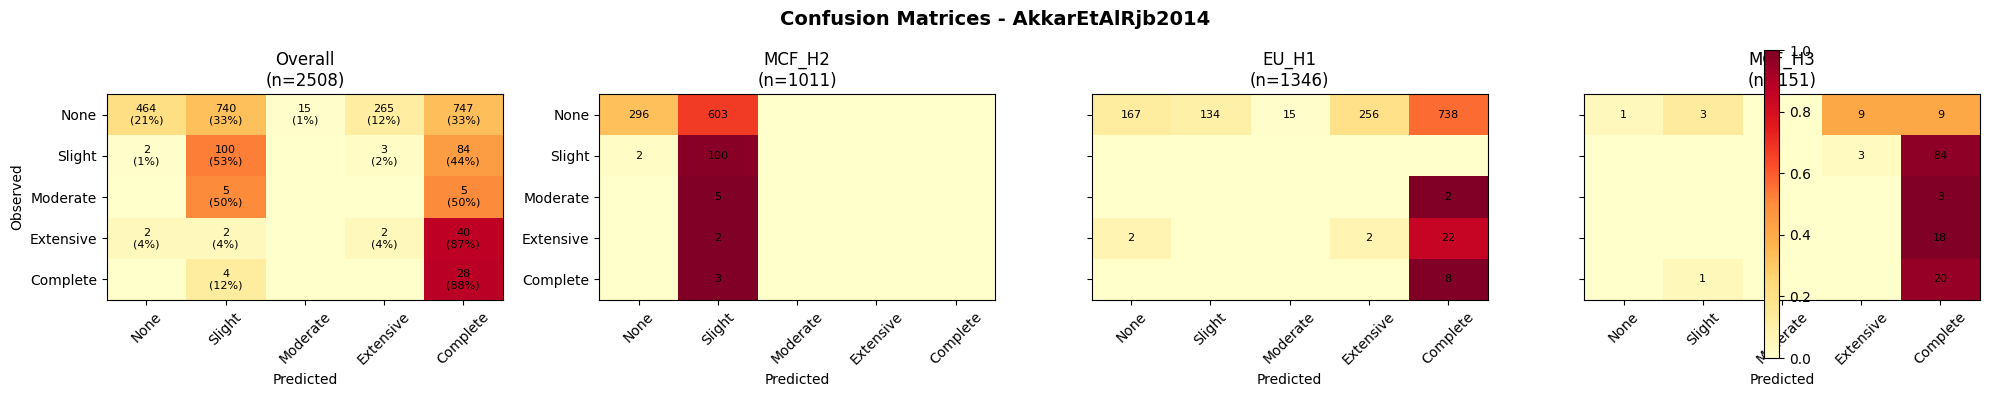

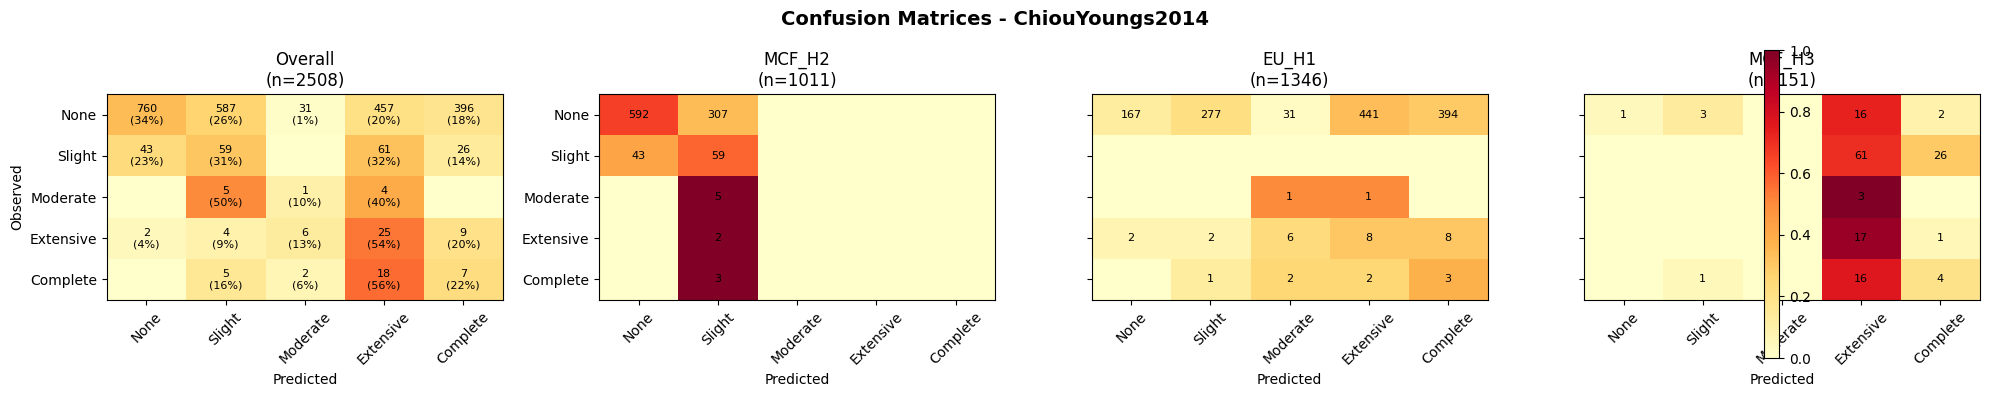

In [ ]:
def plot_confusion_matrices(comparison_data):
    """Create confusion matrices for each GMPE model and building class."""

    damage_states = ['None', 'Slight', 'Moderate', 'Extensive', 'Complete']

    for gmpe_model, data in comparison_data.items():
        building_classes = data['building_class'].unique()
        n_classes = len(building_classes)

        fig, axes = plt.subplots(1, n_classes + 1, figsize=(5*(n_classes+1), 4))

        # Overall confusion matrix
        cm_overall = confusion_matrix(
            data['observed_ds'],
            data['most_probable_ds'],
            labels=damage_states
        )

        # Normalize by row (true label)
        cm_overall_norm = cm_overall.astype('float') / cm_overall.sum(axis=1)[:, np.newaxis]
        cm_overall_norm = np.nan_to_num(cm_overall_norm)

        # Plot overall
        ax = axes[0]
        im = ax.imshow(cm_overall_norm, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

        # Add text annotations
        for i in range(5):
            for j in range(5):
                count = cm_overall[i, j]
                pct = cm_overall_norm[i, j]
                if count > 0:
                    text = ax.text(j, i, f'{count}\n({pct:.0%})',
                                 ha='center', va='center', fontsize=8)

        ax.set_xticks(range(5))
        ax.set_yticks(range(5))
        ax.set_xticklabels(damage_states, rotation=45)
        ax.set_yticklabels(damage_states)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Observed')
        ax.set_title(f'Overall\n(n={len(data)})')

        # Building class specific matrices
        for idx, building_class in enumerate(building_classes):
            ax = axes[idx + 1]
            class_data = data[data['building_class'] == building_class]

            if len(class_data) > 0:
                cm = confusion_matrix(
                    class_data['observed_ds'],
                    class_data['most_probable_ds'],
                    labels=damage_states
                )

                cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                cm_norm = np.nan_to_num(cm_norm)

                im = ax.imshow(cm_norm, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

                for i in range(5):
                    for j in range(5):
                        count = cm[i, j]
                        if count > 0:
                            text = ax.text(j, i, f'{count}',
                                         ha='center', va='center', fontsize=8)

                ax.set_xticks(range(5))
                ax.set_yticks(range(5))
                ax.set_xticklabels(damage_states, rotation=45)
                if idx == 0:
                    ax.set_yticklabels(damage_states)
                else:
                    ax.set_yticklabels([])
                ax.set_xlabel('Predicted')
                ax.set_title(f'{building_class}\n(n={len(class_data)})')

        plt.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.04)
        fig.suptitle(f'Confusion Matrices - {gmpe_model}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

print("\n" + "=" * 70)
print("GENERATING CONFUSION MATRICES")
print("=" * 70)

plot_confusion_matrices(comparison_data)


# 7. DEVIANCE DECOMPOSITION PLOT


GENERATING DEVIANCE DECOMPOSITION PLOTS


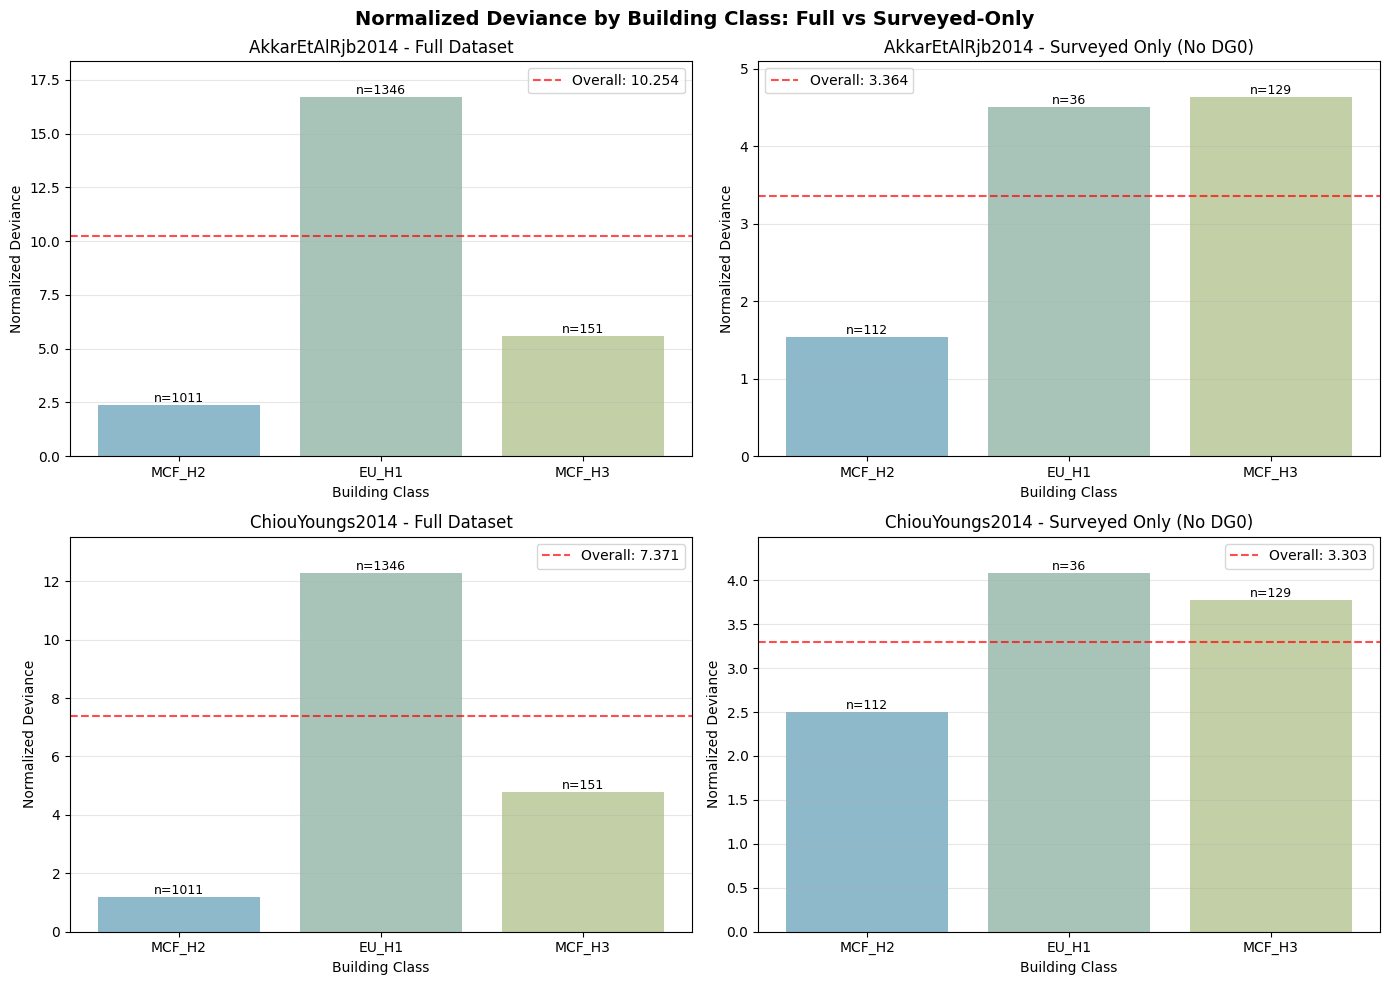

In [ ]:
def plot_deviance_decomposition_surveyed(full_results, surveyed_results,
                                         class_full_results, class_surveyed_results):
    """Create bar plots comparing deviance for full vs surveyed-only data."""

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    for idx, gmpe_model in enumerate(full_results.keys()):
        # Full dataset plot
        ax = axes[idx, 0]

        if gmpe_model in class_full_results:
            classes = []
            deviances = []
            counts = []

            for building_class, metrics in class_full_results[gmpe_model].items():
                classes.append(building_class)
                deviances.append(metrics['normalized_deviance'])
                counts.append(metrics['n_buildings'])

            bars = ax.bar(classes, deviances, color=['#8DB9CA', '#A8C4B8', '#C3CFA6'])

            for bar, count in zip(bars, counts):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'n={count}', ha='center', va='bottom', fontsize=9)

            overall = full_results[gmpe_model]['normalized_deviance']
            ax.axhline(y=overall, color='red', linestyle='--', alpha=0.7,
                      label=f'Overall: {overall:.3f}')

            ax.set_ylabel('Normalized Deviance')
            ax.set_xlabel('Building Class')
            ax.set_title(f'{gmpe_model} - Full Dataset')
            ax.legend()
            ax.grid(True, alpha=0.3, axis='y')
            ax.set_ylim(0, max(deviances + [overall]) * 1.1)

        # Surveyed-only plot
        ax = axes[idx, 1]

        if gmpe_model in class_surveyed_results:
            classes = []
            deviances = []
            counts = []

            for building_class, metrics in class_surveyed_results[gmpe_model].items():
                classes.append(building_class)
                deviances.append(metrics['normalized_deviance'])
                counts.append(metrics['n_buildings'])

            bars = ax.bar(classes, deviances, color=['#8DB9CA', '#A8C4B8', '#C3CFA6'])

            for bar, count in zip(bars, counts):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'n={count}', ha='center', va='bottom', fontsize=9)

            overall = surveyed_results[gmpe_model]['normalized_deviance']
            ax.axhline(y=overall, color='red', linestyle='--', alpha=0.7,
                      label=f'Overall: {overall:.3f}')

            ax.set_ylabel('Normalized Deviance')
            ax.set_xlabel('Building Class')
            ax.set_title(f'{gmpe_model} - Surveyed Only (No DG0)')
            ax.legend()
            ax.grid(True, alpha=0.3, axis='y')
            ax.set_ylim(0, max(deviances + [overall]) * 1.1)

    fig.suptitle('Normalized Deviance by Building Class: Full vs Surveyed-Only',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 70)
print("GENERATING DEVIANCE DECOMPOSITION PLOTS")
print("=" * 70)

# Call both the original and new versions
plot_deviance_decomposition_surveyed(misfit_results, surveyed_misfit_full,
                                    class_specific_results, class_specific_surveyed)

# 8. ANALYSIS EXCLUDING DG0 (ACTUALLY SURVEYED BUILDINGS ONLY)

In [ ]:
print("\n" + "=" * 70)
print("ANALYSIS EXCLUDING DG0 - ACTUALLY SURVEYED BUILDINGS ONLY")
print("=" * 70)
print("\nNote: DG0 was not field-surveyed but added artificially.")
print("This analysis focuses only on buildings with actual damage assessment.\n")

# Filter data to exclude DG0 (None damage state)
surveyed_data = {}
for gmpe_model, data in comparison_data.items():
    surveyed = data[data['observed_ds'] != 'None'].copy()
    surveyed_data[gmpe_model] = surveyed

    print(f"{gmpe_model}:")
    print(f"  Buildings with surveyed damage: {len(surveyed):,} / {len(data):,}")
    print(f"  Percentage actually surveyed: {len(surveyed)/len(data)*100:.1f}%")

# Perform misfit analysis on surveyed buildings only
surveyed_misfit_results = {}

for gmpe_model, data in surveyed_data.items():
    print(f"\n{gmpe_model} - Surveyed Buildings Analysis:")
    print("-" * 50)

    # Show distribution comparison for surveyed buildings
    print(f"  Damage state distribution (surveyed buildings only):")
    obs_dist = data['observed_ds'].value_counts()
    pred_dist = data['most_probable_ds'].value_counts()

    damage_states_surveyed = ['Slight', 'Moderate', 'Extensive', 'Complete']
    for ds in damage_states_surveyed:
        obs_count = obs_dist.get(ds, 0)
        pred_count = pred_dist.get(ds, 0)
        obs_pct = obs_count / len(data) * 100
        pred_pct = pred_count / len(data) * 100
        print(f"    {ds:10s}: Obs={obs_count:3d} ({obs_pct:5.1f}%), Pred={pred_count:3d} ({pred_pct:5.1f}%)")

    # Include "None" predictions for surveyed buildings (this is an error!)
    none_pred = (data['most_probable_ds'] == 'None').sum()
    if none_pred > 0:
        none_pct = none_pred / len(data) * 100
        print(f"    {'None':10s}: Obs=  0 (  0.0%), Pred={none_pred:3d} ({none_pct:5.1f}%) ← Error!")

    # Calculate deviance for surveyed buildings only
    overall_deviance = calculate_multinomial_deviance(
        data['observed_ds'],
        data[['p_exceed_slight', 'p_exceed_moderate',
              'p_exceed_extensive', 'p_exceed_complete']]
    )

    normalized_deviance = overall_deviance / len(data)

    # Calculate kappa
    kappa_p50 = calculate_ordinal_weighted_kappa(
        data['observed_ds'],
        data['most_probable_ds']
    )

    # Accuracy metrics
    accuracy_metrics = calculate_accuracy_metrics(
        data['observed_ds'],
        data['most_probable_ds']
    )

    # Store and display results
    surveyed_misfit_results[gmpe_model] = {
        'total_buildings': len(data),
        'overall_deviance': overall_deviance,
        'normalized_deviance': normalized_deviance,
        'kappa_p50': kappa_p50,
        'accuracy': accuracy_metrics['accuracy'],
        'within_one_accuracy': accuracy_metrics['within_one_accuracy'],
        'over_prediction_rate': accuracy_metrics['over_prediction_rate'],
        'under_prediction_rate': accuracy_metrics['under_prediction_rate']
    }

    print(f"\n  Performance Metrics (surveyed buildings only):")
    print(f"    Normalized deviance: {normalized_deviance:.4f}")
    print(f"    Weighted Kappa: {kappa_p50:.3f}")
    print(f"    Exact accuracy: {accuracy_metrics['accuracy']:.1%}")
    print(f"    Within-one accuracy: {accuracy_metrics['within_one_accuracy']:.1%}")
    print(f"    Over-prediction: {accuracy_metrics['over_prediction_rate']:.1%}")
    print(f"    Under-prediction: {accuracy_metrics['under_prediction_rate']:.1%}")

# Compare full dataset vs surveyed-only results
print("\n" + "=" * 70)
print("COMPARISON: FULL DATASET vs SURVEYED BUILDINGS ONLY")
print("=" * 70)



ANALYSIS EXCLUDING DG0 - ACTUALLY SURVEYED BUILDINGS ONLY

Note: DG0 was not field-surveyed but added artificially.
This analysis focuses only on buildings with actual damage assessment.

AkkarEtAlRjb2014:
  Buildings with surveyed damage: 277 / 2,508
  Percentage actually surveyed: 11.0%
ChiouYoungs2014:
  Buildings with surveyed damage: 277 / 2,508
  Percentage actually surveyed: 11.0%

AkkarEtAlRjb2014 - Surveyed Buildings Analysis:
--------------------------------------------------
  Damage state distribution (surveyed buildings only):
    Slight    : Obs=189 ( 68.2%), Pred=111 ( 40.1%)
    Moderate  : Obs= 10 (  3.6%), Pred=  0 (  0.0%)
    Extensive : Obs= 46 ( 16.6%), Pred=  5 (  1.8%)
    Complete  : Obs= 32 ( 11.6%), Pred=157 ( 56.7%)
    None      : Obs=  0 (  0.0%), Pred=  4 (  1.4%) ← Error!

  Performance Metrics (surveyed buildings only):
    Normalized deviance: 3.3637
    Weighted Kappa: 0.255
    Exact accuracy: 46.9%
    Within-one accuracy: 63.9%
    Over-prediction

# 9. COMPARATIVE VISUALIZATIONS: FULL vs SURVEYED-ONLY


GENERATING COMPARATIVE VISUALIZATIONS

Creating side-by-side confusion matrices...


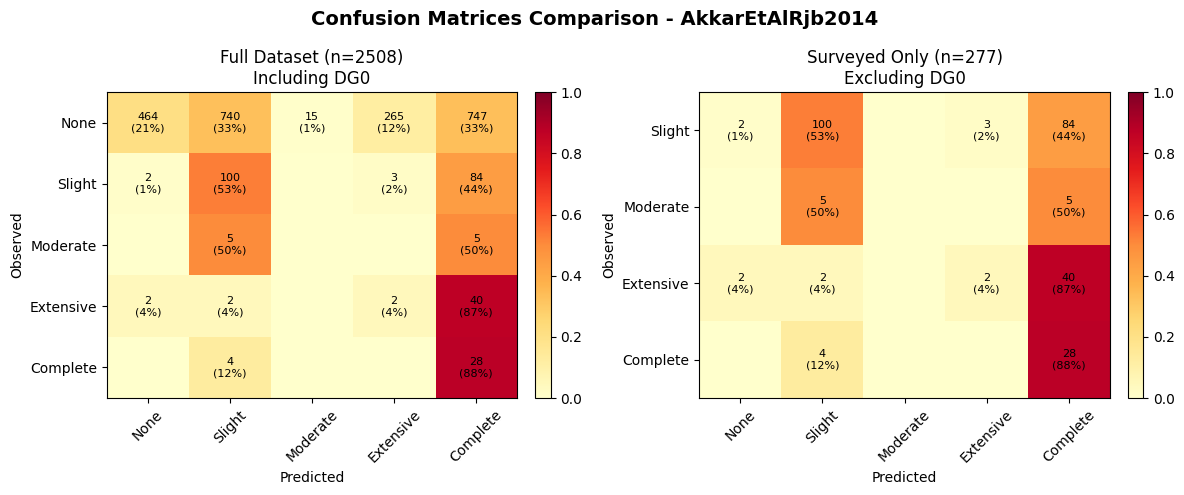

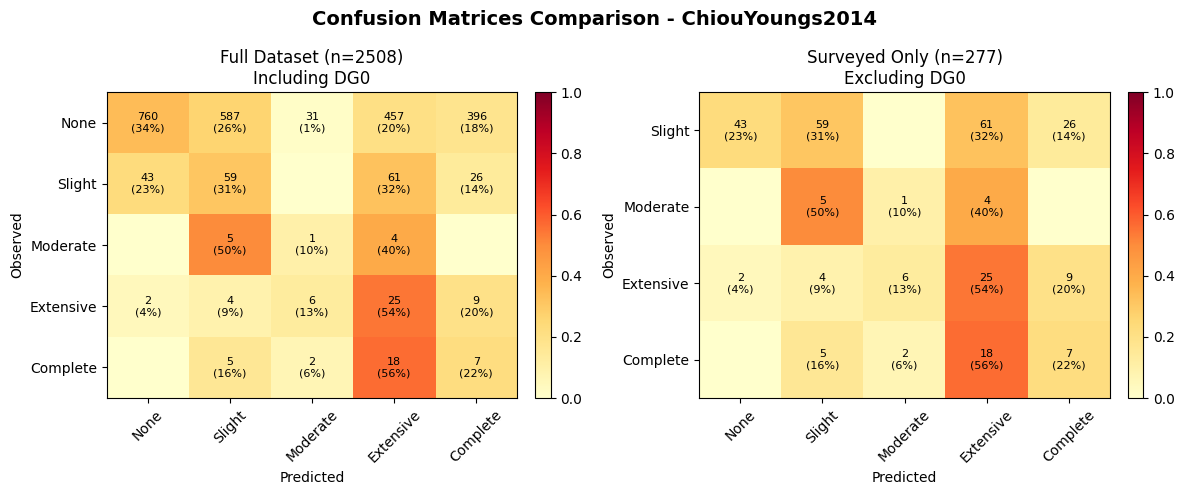


Creating performance metrics comparison...


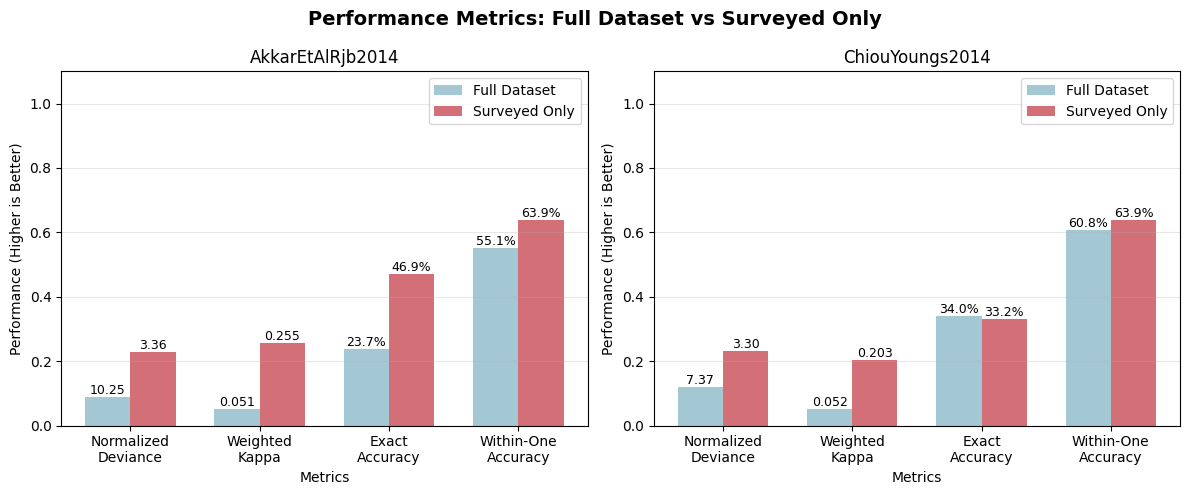


Creating damage state distribution comparison...


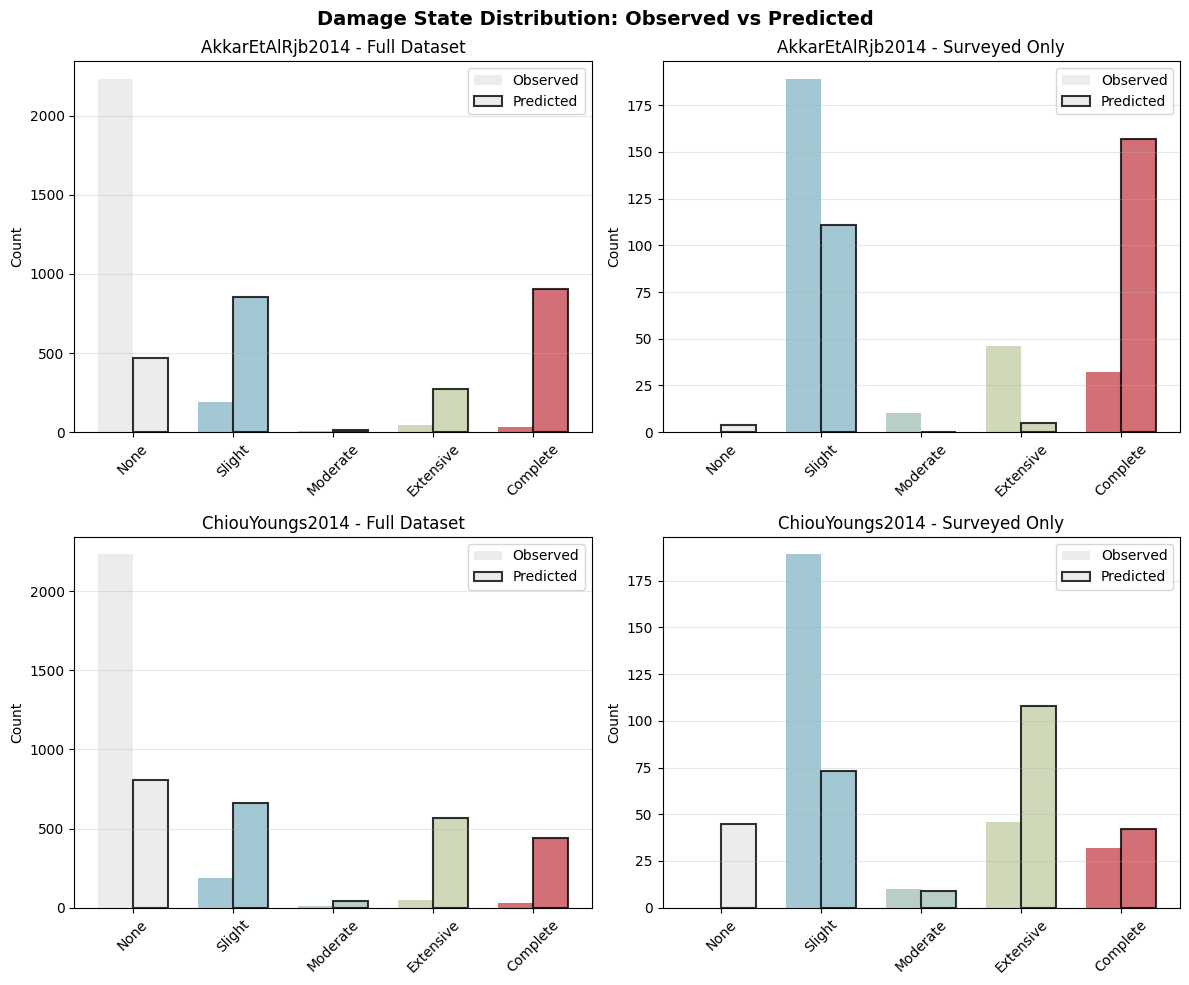

In [ ]:
def plot_comparative_confusion_matrices(full_data, surveyed_data):
    """Create side-by-side confusion matrices for full vs surveyed-only data."""

    damage_states = ['None', 'Slight', 'Moderate', 'Extensive', 'Complete']
    damage_states_surveyed = ['Slight', 'Moderate', 'Extensive', 'Complete']

    for gmpe_model in full_data.keys():
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Full dataset confusion matrix
        ax = axes[0]
        cm_full = confusion_matrix(
            full_data[gmpe_model]['observed_ds'].astype(str),
            full_data[gmpe_model]['most_probable_ds'].astype(str),
            labels=damage_states
        )

        with np.errstate(divide='ignore', invalid='ignore'):
            cm_full_norm = cm_full.astype('float') / cm_full.sum(axis=1)[:, np.newaxis]
            cm_full_norm = np.nan_to_num(cm_full_norm)

        im1 = ax.imshow(cm_full_norm, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

        # Add text annotations
        for i in range(5):
            for j in range(5):
                if cm_full[i, j] > 0:
                    text = ax.text(j, i, f'{cm_full[i, j]}\n({cm_full_norm[i, j]:.0%})',
                                 ha='center', va='center', fontsize=8)

        ax.set_xticks(range(5))
        ax.set_yticks(range(5))
        ax.set_xticklabels(damage_states, rotation=45)
        ax.set_yticklabels(damage_states)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Observed')
        ax.set_title(f'Full Dataset (n={len(full_data[gmpe_model])})\nIncluding DG0')

        # Surveyed-only confusion matrix
        ax = axes[1]
        if gmpe_model in surveyed_data:
            # Create extended confusion matrix including "None" predictions
            cm_surveyed = np.zeros((4, 5))  # 4 observed states, 5 predicted states

            for i, obs_state in enumerate(damage_states_surveyed):
                for j, pred_state in enumerate(damage_states):
                    count = ((surveyed_data[gmpe_model]['observed_ds'] == obs_state) &
                            (surveyed_data[gmpe_model]['most_probable_ds'] == pred_state)).sum()
                    cm_surveyed[i, j] = count

            with np.errstate(divide='ignore', invalid='ignore'):
                cm_surveyed_norm = cm_surveyed.astype('float') / cm_surveyed.sum(axis=1)[:, np.newaxis]
                cm_surveyed_norm = np.nan_to_num(cm_surveyed_norm)

            im2 = ax.imshow(cm_surveyed_norm, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

            # Add text annotations
            for i in range(4):
                for j in range(5):
                    if cm_surveyed[i, j] > 0:
                        text = ax.text(j, i, f'{int(cm_surveyed[i, j])}\n({cm_surveyed_norm[i, j]:.0%})',
                                     ha='center', va='center', fontsize=8)

            ax.set_xticks(range(5))
            ax.set_yticks(range(4))
            ax.set_xticklabels(damage_states, rotation=45)
            ax.set_yticklabels(damage_states_surveyed)
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Observed')
            ax.set_title(f'Surveyed Only (n={len(surveyed_data[gmpe_model])})\nExcluding DG0')

        # Add colorbars
        plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
        plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

        fig.suptitle(f'Confusion Matrices Comparison - {gmpe_model}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

def plot_metric_comparison(full_results, surveyed_results):
    """Bar plot comparing metrics between full and surveyed-only datasets."""

    metrics = ['normalized_deviance', 'kappa_p50', 'accuracy', 'within_one_accuracy']
    metric_labels = ['Normalized\nDeviance', 'Weighted\nKappa', 'Exact\nAccuracy', 'Within-One\nAccuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for idx, gmpe_model in enumerate(full_results.keys()):
        ax = axes[idx]

        x = np.arange(len(metrics))
        width = 0.35

        # Get values
        full_vals = []
        surveyed_vals = []

        for metric in metrics:
            if metric == 'normalized_deviance':
                # Invert deviance for visualization (lower is better → higher bar)
                full_val = 1 / (1 + full_results[gmpe_model][metric])
                surveyed_val = 1 / (1 + surveyed_results[gmpe_model][metric])
            else:
                full_val = full_results[gmpe_model].get(metric, 0)
                surveyed_val = surveyed_results[gmpe_model].get(metric, 0)

            full_vals.append(full_val)
            surveyed_vals.append(surveyed_val)

        # Create bars
        bars1 = ax.bar(x - width/2, full_vals, width, label='Full Dataset', color='#8DB9CA', alpha=0.8)
        bars2 = ax.bar(x + width/2, surveyed_vals, width, label='Surveyed Only', color='#C94B54', alpha=0.8)

        # Add value labels
        for bars in [bars1, bars2]:
            for bar, metric, orig_val in zip(bars, metrics,
                                            [full_results[gmpe_model].get(m, 0) if bars == bars1
                                             else surveyed_results[gmpe_model].get(m, 0)
                                             for m in metrics]):
                height = bar.get_height()
                if metric == 'normalized_deviance':
                    label = f'{orig_val:.2f}'
                elif metric in ['accuracy', 'within_one_accuracy']:
                    label = f'{orig_val:.1%}'
                else:
                    label = f'{orig_val:.3f}'

                ax.text(bar.get_x() + bar.get_width()/2., height,
                       label, ha='center', va='bottom', fontsize=9)

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Performance (Higher is Better)')
        ax.set_title(f'{gmpe_model}')
        ax.set_xticks(x)
        ax.set_xticklabels(metric_labels)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(0, 1.1)

    fig.suptitle('Performance Metrics: Full Dataset vs Surveyed Only', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_damage_state_distribution_comparison(full_data, surveyed_data):
    """Compare observed vs predicted damage state distributions."""

    damage_states = ['None', 'Slight', 'Moderate', 'Extensive', 'Complete']
    colors = ['#E8E8E8', '#8DB9CA', '#A8C4B8', '#C3CFA6', '#C94B54']

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    for idx, gmpe_model in enumerate(full_data.keys()):
        # Full dataset
        ax = axes[idx, 0]

        obs_counts = full_data[gmpe_model]['observed_ds'].value_counts()
        pred_counts = full_data[gmpe_model]['most_probable_ds'].value_counts()

        x = np.arange(len(damage_states))
        width = 0.35

        obs_vals = [obs_counts.get(ds, 0) for ds in damage_states]
        pred_vals = [pred_counts.get(ds, 0) for ds in damage_states]

        bars1 = ax.bar(x - width/2, obs_vals, width, label='Observed', alpha=0.8)
        bars2 = ax.bar(x + width/2, pred_vals, width, label='Predicted', alpha=0.8)

        # Color bars by damage state
        for bar, color in zip(bars1, colors):
            bar.set_facecolor(color)
        for bar, color in zip(bars2, colors):
            bar.set_facecolor(color)
            bar.set_edgecolor('black')
            bar.set_linewidth(1.5)

        ax.set_ylabel('Count')
        ax.set_title(f'{gmpe_model} - Full Dataset')
        ax.set_xticks(x)
        ax.set_xticklabels(damage_states, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        # Surveyed only
        ax = axes[idx, 1]

        if gmpe_model in surveyed_data:
            obs_counts = surveyed_data[gmpe_model]['observed_ds'].value_counts()
            pred_counts = surveyed_data[gmpe_model]['most_probable_ds'].value_counts()

            obs_vals = [obs_counts.get(ds, 0) for ds in damage_states]
            pred_vals = [pred_counts.get(ds, 0) for ds in damage_states]

            bars1 = ax.bar(x - width/2, obs_vals, width, label='Observed', alpha=0.8)
            bars2 = ax.bar(x + width/2, pred_vals, width, label='Predicted', alpha=0.8)

            for bar, color in zip(bars1, colors):
                bar.set_facecolor(color)
            for bar, color in zip(bars2, colors):
                bar.set_facecolor(color)
                bar.set_edgecolor('black')
                bar.set_linewidth(1.5)

            ax.set_ylabel('Count')
            ax.set_title(f'{gmpe_model} - Surveyed Only')
            ax.set_xticks(x)
            ax.set_xticklabels(damage_states, rotation=45)
            ax.legend()
            ax.grid(True, alpha=0.3, axis='y')

    fig.suptitle('Damage State Distribution: Observed vs Predicted', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 70)
print("GENERATING COMPARATIVE VISUALIZATIONS")
print("=" * 70)

print("\nCreating side-by-side confusion matrices...")
plot_comparative_confusion_matrices(comparison_data, surveyed_data)

print("\nCreating performance metrics comparison...")
plot_metric_comparison(misfit_results, surveyed_misfit_results)

print("\nCreating damage state distribution comparison...")
plot_damage_state_distribution_comparison(comparison_data, surveyed_data)

# 10. ADDITIONAL DIAGNOSTIC ANALYSES

In [ ]:
print("\n" + "=" * 70)
print("ADDITIONAL DIAGNOSTIC ANALYSES")
print("=" * 70)

def analyze_imt_threshold_performance(data):
    """Analyze performance at different IMT thresholds."""

    print("\nIMT Threshold Analysis:")
    print("-" * 50)

    for gmpe_model, df in data.items():
        print(f"\n{gmpe_model}:")

        # Analyze IMT values for correct vs incorrect predictions
        df['correct'] = df['observed_ds'] == df['most_probable_ds']

        print(f"  Mean IMT by prediction accuracy:")
        print(f"    Correct predictions: {df[df['correct']]['imt_p50'].mean():.3f}g")
        print(f"    Incorrect predictions: {df[~df['correct']]['imt_p50'].mean():.3f}g")

        # Analyze IMT ranges where predictions fail
        print(f"\n  IMT ranges by observed damage:")
        for ds in ['None', 'Slight', 'Moderate', 'Extensive', 'Complete']:
            ds_data = df[df['observed_ds'] == ds]
            if len(ds_data) > 0:
                print(f"    {ds}: {ds_data['imt_p50'].mean():.3f}g ± {ds_data['imt_p50'].std():.3f}g")

        # Find critical IMT where damage begins
        none_data = df[df['observed_ds'] == 'None']
        damaged_data = df[df['observed_ds'] != 'None']

        if len(none_data) > 0 and len(damaged_data) > 0:
            none_95th = none_data['imt_p50'].quantile(0.95)
            damaged_5th = damaged_data['imt_p50'].quantile(0.05)

            print(f"\n  Critical IMT threshold analysis:")
            print(f"    95th percentile of undamaged: {none_95th:.3f}g")
            print(f"    5th percentile of damaged: {damaged_5th:.3f}g")
            print(f"    Overlap zone: {damaged_5th:.3f}g - {none_95th:.3f}g")

analyze_imt_threshold_performance(comparison_data)

def analyze_building_class_performance(full_data, surveyed_data):
    """Detailed analysis by building class."""

    print("\n" + "=" * 70)
    print("BUILDING CLASS-SPECIFIC PERFORMANCE")
    print("=" * 70)

    for gmpe_model in full_data.keys():
        print(f"\n{gmpe_model}:")

        for building_class in full_data[gmpe_model]['building_class'].unique():
            print(f"\n  {building_class}:")

            # Full dataset
            class_full = full_data[gmpe_model][full_data[gmpe_model]['building_class'] == building_class]
            accuracy_full = (class_full['observed_ds'] == class_full['most_probable_ds']).mean()

            # Surveyed only
            class_surveyed = surveyed_data[gmpe_model][surveyed_data[gmpe_model]['building_class'] == building_class]
            accuracy_surveyed = (class_surveyed['observed_ds'] == class_surveyed['most_probable_ds']).mean() if len(class_surveyed) > 0 else 0

            print(f"    Full dataset: n={len(class_full)}, accuracy={accuracy_full:.1%}")
            print(f"    Surveyed only: n={len(class_surveyed)}, accuracy={accuracy_surveyed:.1%}")

            # Damage state distribution for this class
            if len(class_surveyed) > 0:
                obs_dist = class_surveyed['observed_ds'].value_counts()
                pred_dist = class_surveyed['most_probable_ds'].value_counts()

                print(f"    Surveyed damage distribution:")
                for ds in ['Slight', 'Moderate', 'Extensive', 'Complete']:
                    obs = obs_dist.get(ds, 0)
                    pred = pred_dist.get(ds, 0)
                    print(f"      {ds}: Obs={obs}, Pred={pred}")

analyze_building_class_performance(comparison_data, surveyed_data)


ADDITIONAL DIAGNOSTIC ANALYSES

IMT Threshold Analysis:
--------------------------------------------------

AkkarEtAlRjb2014:
  Mean IMT by prediction accuracy:
    Correct predictions: 0.318g
    Incorrect predictions: 0.697g

  IMT ranges by observed damage:
    None: 0.602g ± 0.290g
    Slight: 0.640g ± 0.155g
    Moderate: 0.740g ± 0.227g
    Extensive: 0.677g ± 0.238g
    Complete: 0.624g ± 0.213g

  Critical IMT threshold analysis:
    95th percentile of undamaged: 0.961g
    5th percentile of damaged: 0.442g
    Overlap zone: 0.442g - 0.961g

ChiouYoungs2014:
  Mean IMT by prediction accuracy:
    Correct predictions: 0.327g
    Incorrect predictions: 0.531g

  IMT ranges by observed damage:
    None: 0.461g ± 0.182g
    Slight: 0.463g ± 0.063g
    Moderate: 0.502g ± 0.060g
    Extensive: 0.485g ± 0.126g
    Complete: 0.464g ± 0.095g

  Critical IMT threshold analysis:
    95th percentile of undamaged: 0.721g
    5th percentile of damaged: 0.391g
    Overlap zone: 0.391g - 0.72

# 11. EMPIRICAL FRAGILITY CURVES FROM MOROCCO DATA


EMPIRICAL FRAGILITY CURVES FROM OBSERVED DATA

AkkarEtAlRjb2014 - Empirical Fragility Analysis:
--------------------------------------------------


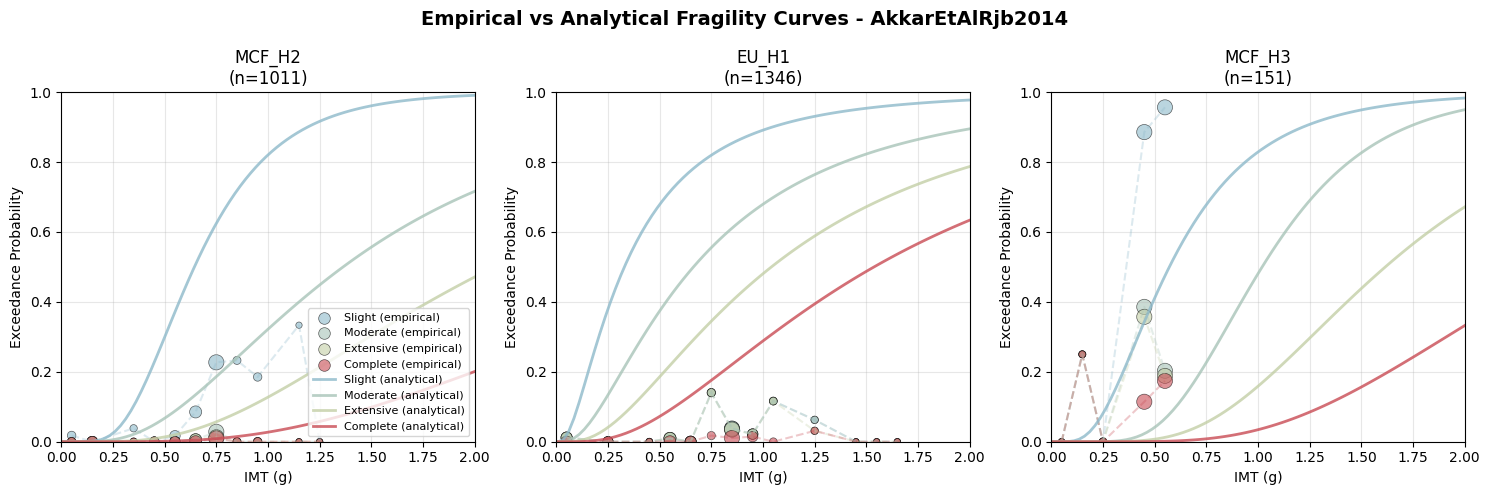


  Empirical damage thresholds (50% exceedance):
    MCF_H2:
      Slight: ~0.722g
      Moderate: ~0.722g
    EU_H1:
      Slight: ~0.887g
      Moderate: ~0.887g
      Extensive: ~0.887g
      Complete: ~0.895g
    MCF_H3:
      Slight: ~0.500g
      Moderate: ~0.489g
      Extensive: ~0.489g
      Complete: ~0.516g

ChiouYoungs2014 - Empirical Fragility Analysis:
--------------------------------------------------


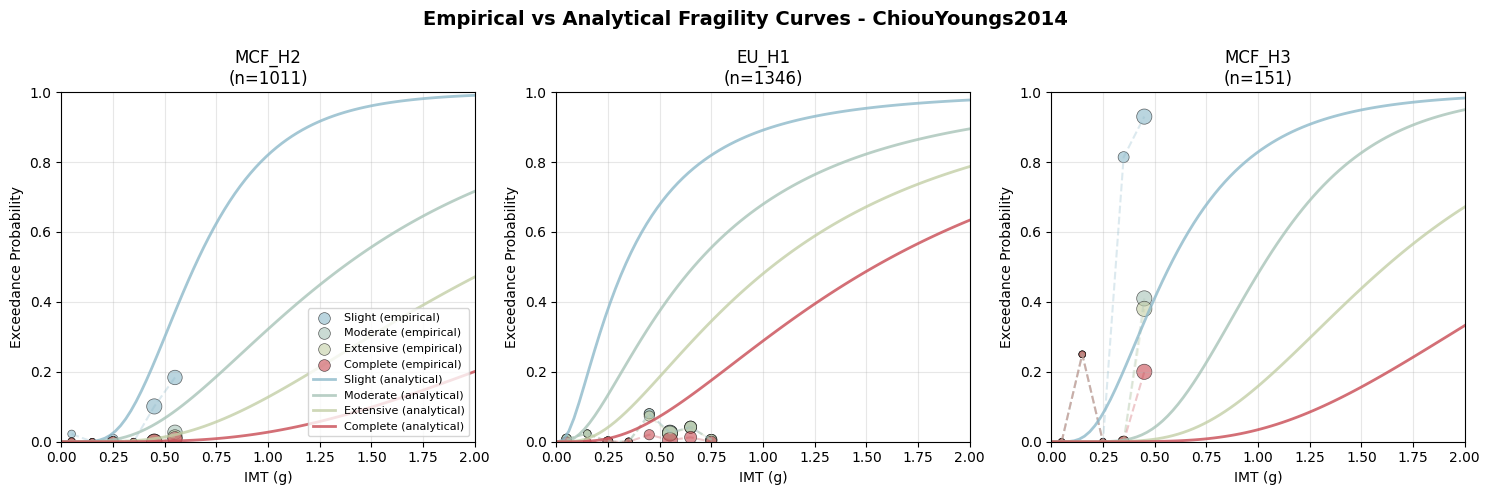


  Empirical damage thresholds (50% exceedance):
    MCF_H2:
      Slight: ~0.529g
      Moderate: ~0.535g
    EU_H1:
      Slight: ~0.519g
      Moderate: ~0.519g
      Extensive: ~0.521g
      Complete: ~0.518g
    MCF_H3:
      Slight: ~0.422g
      Moderate: ~0.422g
      Extensive: ~0.422g
      Complete: ~0.420g

AkkarEtAlRjb2014 - Empirical Fragility Analysis:
--------------------------------------------------


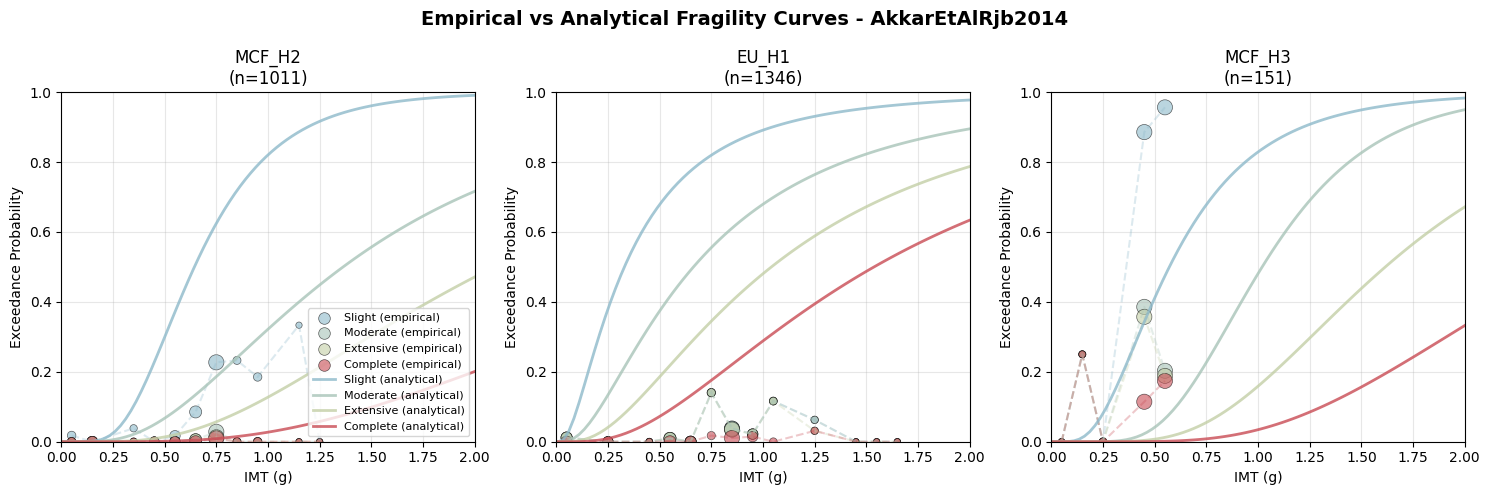


  Empirical damage thresholds (50% exceedance):
    MCF_H2:
      Slight: ~0.722g
      Moderate: ~0.722g
    EU_H1:
      Slight: ~0.887g
      Moderate: ~0.887g
      Extensive: ~0.887g
      Complete: ~0.895g
    MCF_H3:
      Slight: ~0.500g
      Moderate: ~0.489g
      Extensive: ~0.489g
      Complete: ~0.516g

ChiouYoungs2014 - Empirical Fragility Analysis:
--------------------------------------------------


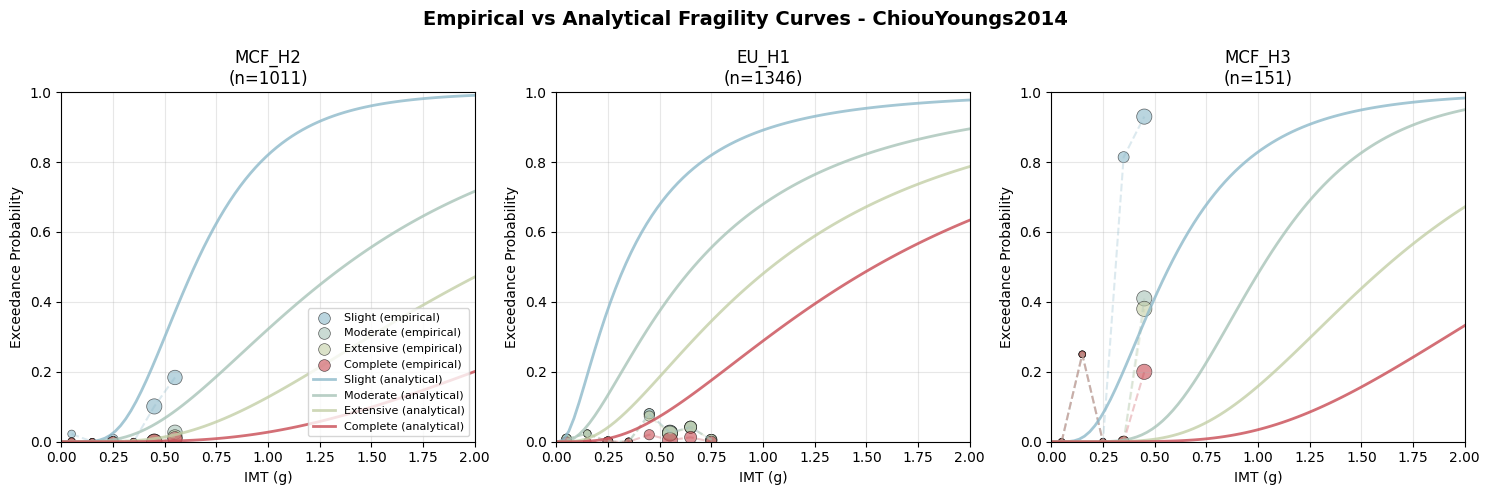


  Empirical damage thresholds (50% exceedance):
    MCF_H2:
      Slight: ~0.529g
      Moderate: ~0.535g
    EU_H1:
      Slight: ~0.519g
      Moderate: ~0.519g
      Extensive: ~0.521g
      Complete: ~0.518g
    MCF_H3:
      Slight: ~0.422g
      Moderate: ~0.422g
      Extensive: ~0.422g
      Complete: ~0.420g


In [ ]:
print("\n" + "=" * 70)
print("EMPIRICAL FRAGILITY CURVES FROM OBSERVED DATA")
print("=" * 70)

def derive_empirical_fragility_curves(data, fragility_functions):
    """Derive empirical fragility curves from observed Morocco earthquake data."""

    for gmpe_model, df in data.items():
        print(f"\n{gmpe_model} - Empirical Fragility Analysis:")
        print("-" * 50)

        # Define IMT bins
        imt_bins = np.arange(0, 2.5, 0.1)
        bin_centers = (imt_bins[:-1] + imt_bins[1:]) / 2

        # Create figure for this GMPE
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        building_classes = df['building_class'].unique()

        for idx, building_class in enumerate(building_classes[:3]):
            ax = axes[idx]
            class_data = df[df['building_class'] == building_class]

            if len(class_data) < 10:
                ax.text(0.5, 0.5, f'Insufficient data\n(n={len(class_data)})',
                       ha='center', va='center', fontsize=12)
                ax.set_title(building_class)
                continue

            # Calculate empirical exceedance rates for each damage state
            empirical_curves = {}
            damage_states = ['slight', 'moderate', 'extensive', 'complete']
            colors = {'slight': '#8DB9CA', 'moderate': '#A8C4B8',
                     'extensive': '#C3CFA6', 'complete': '#C94B54'}

            for ds, color in zip(damage_states, colors.values()):
                exceedance_rates = []
                sample_sizes = []

                for i in range(len(imt_bins)-1):
                    bin_data = class_data[
                        (class_data['imt_p50'] >= imt_bins[i]) &
                        (class_data['imt_p50'] < imt_bins[i+1])
                    ]

                    if len(bin_data) > 0:
                        # Calculate exceedance rate
                        if ds == 'slight':
                            rate = (bin_data['observed_ds'] != 'None').mean()
                        elif ds == 'moderate':
                            rate = bin_data['observed_ds'].isin(['Moderate', 'Extensive', 'Complete']).mean()
                        elif ds == 'extensive':
                            rate = bin_data['observed_ds'].isin(['Extensive', 'Complete']).mean()
                        else:  # complete
                            rate = (bin_data['observed_ds'] == 'Complete').mean()

                        exceedance_rates.append(rate)
                        sample_sizes.append(len(bin_data))
                    else:
                        exceedance_rates.append(np.nan)
                        sample_sizes.append(0)

                empirical_curves[ds] = (exceedance_rates, sample_sizes)

                # Plot empirical points with size based on sample size
                valid_idx = ~np.isnan(exceedance_rates)
                valid_centers = bin_centers[valid_idx]
                valid_rates = np.array(exceedance_rates)[valid_idx]
                valid_sizes = np.array(sample_sizes)[valid_idx]

                # Scale point sizes
                point_sizes = 20 + (valid_sizes / max(valid_sizes) * 100) if len(valid_sizes) > 0 else [20]

                ax.scatter(valid_centers, valid_rates, s=point_sizes,
                          color=color, alpha=0.6, label=f'{ds.capitalize()} (empirical)',
                          edgecolors='black', linewidth=0.5)

                # Connect points with line
                if len(valid_centers) > 1:
                    ax.plot(valid_centers, valid_rates, '--', color=color, alpha=0.3)

            # Overlay analytical fragility curves if available
            if building_class in fragility_functions:
                imt_range = np.linspace(0.01, 2.5, 100)
                params = fragility_functions[building_class]['parameters']

                for ds_name, ds_params in params['damage_states'].items():
                    mean_ln = ds_params['mean_ln']
                    stddev = ds_params['stddev']
                    analytical_probs = norm.cdf((np.log(imt_range) - mean_ln) / stddev)

                    ax.plot(imt_range, analytical_probs,
                           color=colors.get(ds_name, 'gray'),
                           linewidth=2, alpha=0.8,
                           label=f'{ds_name.capitalize()} (analytical)')

            ax.set_xlabel('IMT (g)')
            ax.set_ylabel('Exceedance Probability')
            ax.set_title(f'{building_class}\n(n={len(class_data)})')
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, 2.0)
            ax.set_ylim(0, 1.0)

            if idx == 0:
                ax.legend(loc='lower right', fontsize=8)

        fig.suptitle(f'Empirical vs Analytical Fragility Curves - {gmpe_model}',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print(f"\n  Empirical damage thresholds (50% exceedance):")
        for building_class in building_classes[:3]:
            class_data = df[df['building_class'] == building_class]
            if len(class_data) > 10:
                print(f"    {building_class}:")

                # Find approximate thresholds
                for ds in ['slight', 'moderate', 'extensive', 'complete']:
                    if ds == 'slight':
                        damaged = class_data[class_data['observed_ds'] != 'None']
                    elif ds == 'moderate':
                        damaged = class_data[class_data['observed_ds'].isin(['Moderate', 'Extensive', 'Complete'])]
                    elif ds == 'extensive':
                        damaged = class_data[class_data['observed_ds'].isin(['Extensive', 'Complete'])]
                    else:
                        damaged = class_data[class_data['observed_ds'] == 'Complete']

                    if len(damaged) > 5:
                        threshold = damaged['imt_p50'].median()
                        print(f"      {ds.capitalize()}: ~{threshold:.3f}g")

# Then, before calling derive_empirical_fragility_curves, add:
fragility_functions = load_fragility_parameters()
derive_empirical_fragility_curves(comparison_data, fragility_functions)

derive_empirical_fragility_curves(comparison_data, fragility_functions)

# 12. UNCERTAINTY ANALYSIS ACROSS PERCENTILES


UNCERTAINTY ANALYSIS: PREDICTION CONSISTENCY ACROSS PERCENTILES

UNCERTAINTY ANALYSIS WITH ACCURACY CATEGORIES

AkkarEtAlRjb2014 - Full Dataset (including DG0):
  Analyzing 2508 buildings


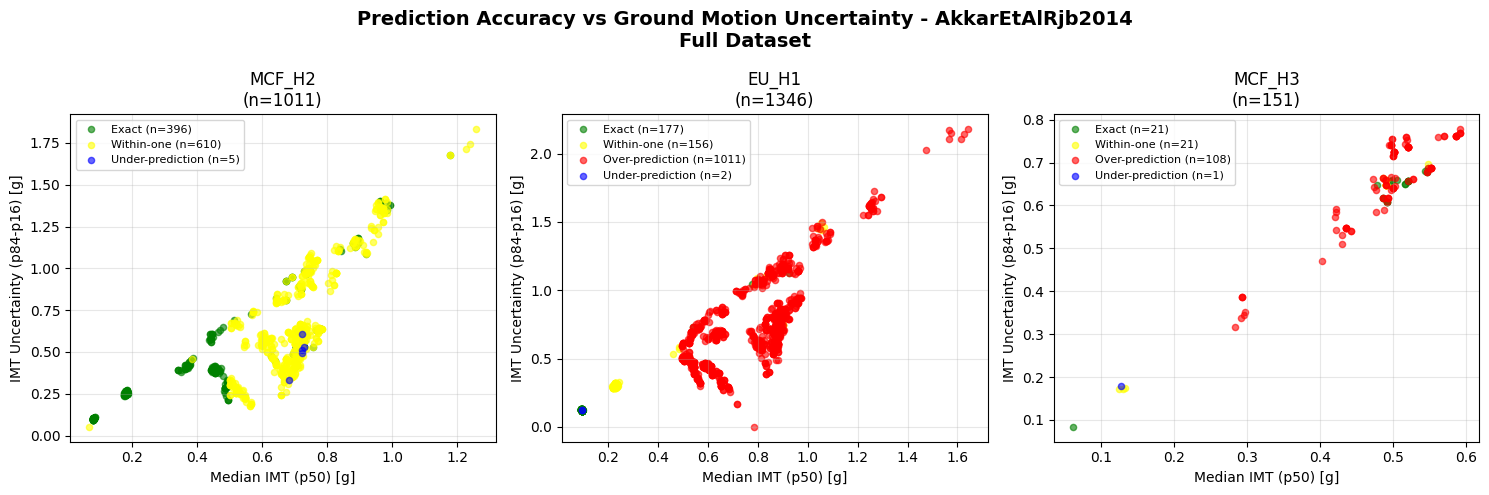


  Accuracy categories by IMT uncertainty:
    Exact: 594 buildings, mean IMT=0.318g, mean spread=0.345g
    Within-one: 787 buildings, mean IMT=0.618g, mean spread=0.606g
    Over-prediction: 1119 buildings, mean IMT=0.754g, mean spread=0.768g
    Under-prediction: 8 buildings, mean IMT=0.487g, mean spread=0.363g

ChiouYoungs2014 - Full Dataset (including DG0):
  Analyzing 2508 buildings


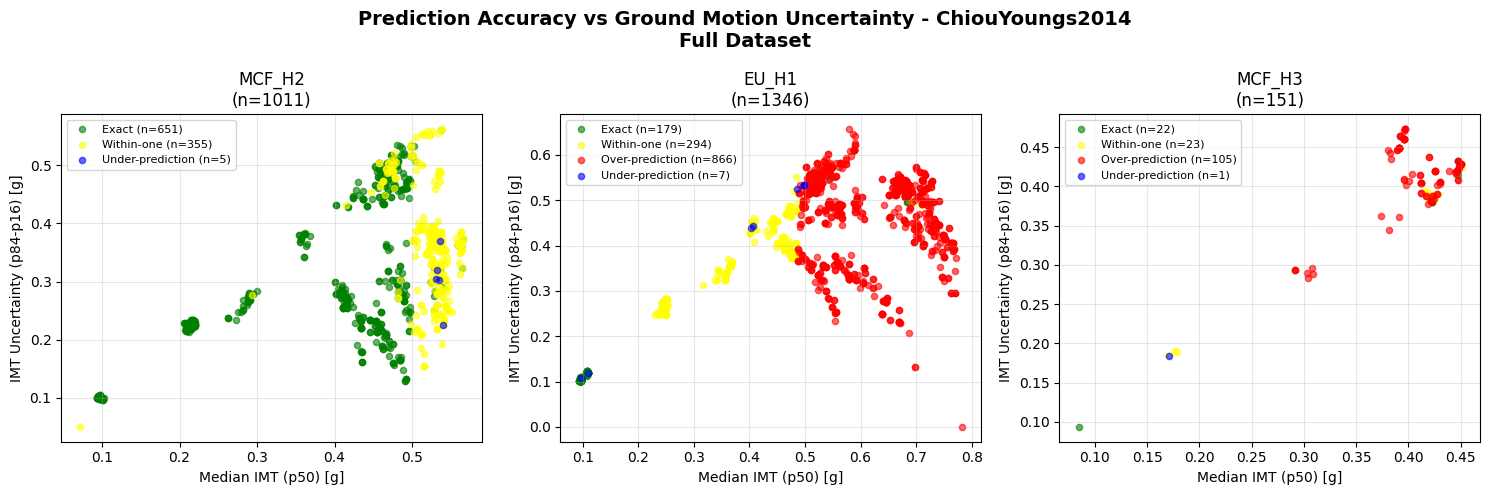


  Accuracy categories by IMT uncertainty:
    Exact: 852 buildings, mean IMT=0.327g, mean spread=0.268g
    Within-one: 672 buildings, mean IMT=0.446g, mean spread=0.354g
    Over-prediction: 971 buildings, mean IMT=0.592g, mean spread=0.459g
    Under-prediction: 13 buildings, mean IMT=0.411g, mean spread=0.339g


NameError: name 'analyze_uncertainty_with_accuracy_categories' is not defined

In [ ]:
print("\n" + "=" * 70)
print("UNCERTAINTY ANALYSIS: PREDICTION CONSISTENCY ACROSS PERCENTILES")
print("=" * 70)

def analyze_uncertainty_with_accuracy_categories_full(data):
    """Create uncertainty plots using accuracy categories for full dataset including DG0."""

    for gmpe_model, df in data.items():
        print(f"\n{gmpe_model} - Full Dataset (including DG0):")
        print(f"  Analyzing {len(df)} buildings")

        # Calculate IMT spread
        df['imt_spread'] = df['imt_p84'] - df['imt_p16']

        # Categorize predictions
        ds_to_ordinal = {'None': 0, 'Slight': 1, 'Moderate': 2, 'Extensive': 3, 'Complete': 4}

        df['obs_ord'] = df['observed_ds'].map(ds_to_ordinal)
        df['pred_ord'] = df['most_probable_ds'].map(ds_to_ordinal)
        df['error'] = df['pred_ord'] - df['obs_ord']

        # Categorize each building
        df['category'] = 'Exact'  # Default
        df.loc[df['error'] > 0, 'category'] = 'Over-prediction'
        df.loc[df['error'] < 0, 'category'] = 'Under-prediction'
        df.loc[abs(df['error']) == 1, 'category'] = 'Within-one'
        df.loc[df['error'] == 0, 'category'] = 'Exact'

        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Colors for categories
        category_colors = {
            'Exact': 'green',
            'Within-one': 'yellow',
            'Over-prediction': 'red',
            'Under-prediction': 'blue'
        }

        for idx, building_class in enumerate(df['building_class'].unique()[:3]):
            ax = axes[idx]
            class_data = df[df['building_class'] == building_class]

            # Plot each category
            for category, color in category_colors.items():
                cat_data = class_data[class_data['category'] == category]
                if len(cat_data) > 0:
                    ax.scatter(cat_data['imt_p50'], cat_data['imt_spread'],
                             alpha=0.6, s=20, color=color,
                             label=f'{category} (n={len(cat_data)})')

            ax.set_xlabel('Median IMT (p50) [g]')
            ax.set_ylabel('IMT Uncertainty (p84-p16) [g]')
            ax.set_title(f'{building_class}\n(n={len(class_data)})')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)

        fig.suptitle(f'Prediction Accuracy vs Ground Motion Uncertainty - {gmpe_model}\nFull Dataset',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Print statistics
        print("\n  Accuracy categories by IMT uncertainty:")
        for category in ['Exact', 'Within-one', 'Over-prediction', 'Under-prediction']:
            cat_data = df[df['category'] == category]
            if len(cat_data) > 0:
                mean_spread = cat_data['imt_spread'].mean()
                mean_imt = cat_data['imt_p50'].mean()
                print(f"    {category}: {len(cat_data)} buildings, "
                      f"mean IMT={mean_imt:.3f}g, mean spread={mean_spread:.3f}g")

# Call both functions to compare
print("\n" + "=" * 70)
print("UNCERTAINTY ANALYSIS WITH ACCURACY CATEGORIES")
print("=" * 70)

# Full dataset
analyze_uncertainty_with_accuracy_categories_full(comparison_data)

# Surveyed only
analyze_uncertainty_with_accuracy_categories(comparison_data)


UNCERTAINTY ANALYSIS: SURVEYED BUILDINGS ONLY (EXCLUDING DG0)

AkkarEtAlRjb2014 - Surveyed Buildings Only:
  Analyzing 277 surveyed buildings


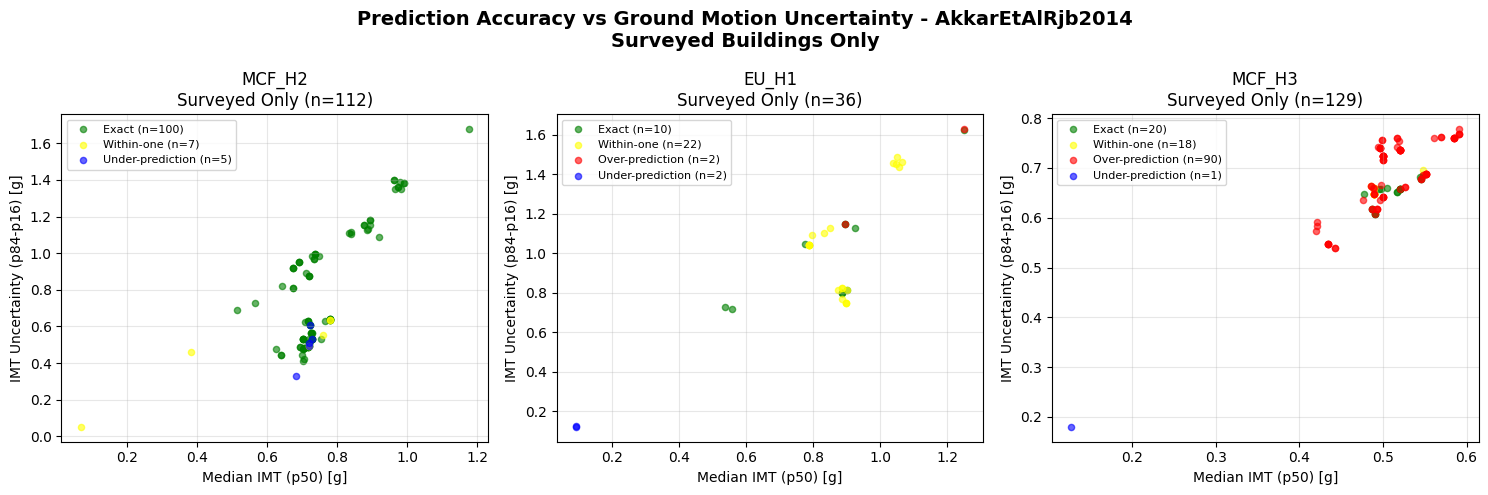


  Accuracy categories by IMT uncertainty:
    Exact: 130 buildings, mean IMT=0.729g, mean spread=0.770g
    Within-one: 47 buildings, mean IMT=0.695g, mean spread=0.814g
    Over-prediction: 92 buildings, mean IMT=0.523g, mean spread=0.705g
    Under-prediction: 8 buildings, mean IMT=0.487g, mean spread=0.363g

ChiouYoungs2014 - Surveyed Buildings Only:
  Analyzing 277 surveyed buildings


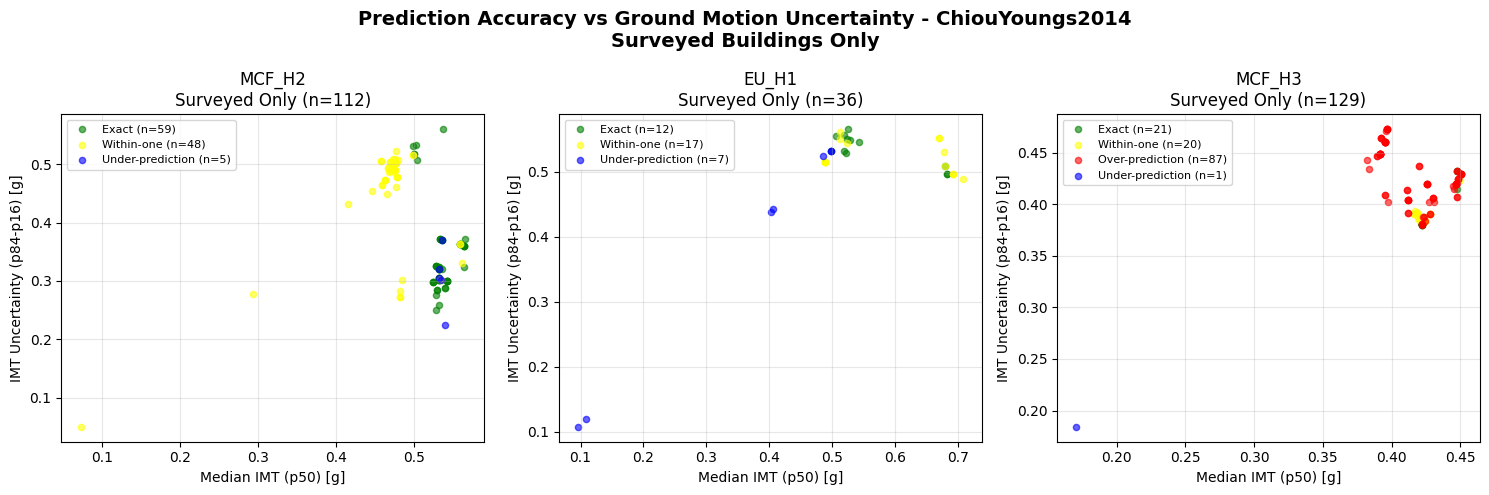


  Accuracy categories by IMT uncertainty:
    Exact: 92 buildings, mean IMT=0.514g, mean spread=0.378g
    Within-one: 85 buildings, mean IMT=0.480g, mean spread=0.446g
    Over-prediction: 87 buildings, mean IMT=0.417g, mean spread=0.428g
    Under-prediction: 13 buildings, mean IMT=0.411g, mean spread=0.339g


In [ ]:
print("\n" + "=" * 70)
print("UNCERTAINTY ANALYSIS: SURVEYED BUILDINGS ONLY (EXCLUDING DG0)")
print("=" * 70)

def analyze_uncertainty_with_accuracy_categories(data):
    """Create uncertainty plots using accuracy categories instead of consistency."""

    for gmpe_model, df_full in data.items():
        # Filter to exclude DG0/None for surveyed-only analysis
        df = df_full[df_full['observed_ds'] != 'None'].copy()

        print(f"\n{gmpe_model} - Surveyed Buildings Only:")
        print(f"  Analyzing {len(df)} surveyed buildings")

        # Calculate IMT spread
        df['imt_spread'] = df['imt_p84'] - df['imt_p16']

        # Categorize predictions
        ds_to_ordinal = {'None': 0, 'Slight': 1, 'Moderate': 2, 'Extensive': 3, 'Complete': 4}

        df['obs_ord'] = df['observed_ds'].map(ds_to_ordinal)
        df['pred_ord'] = df['most_probable_ds'].map(ds_to_ordinal)
        df['error'] = df['pred_ord'] - df['obs_ord']

        # Categorize each building
        df['category'] = 'Exact'  # Default
        df.loc[df['error'] > 0, 'category'] = 'Over-prediction'
        df.loc[df['error'] < 0, 'category'] = 'Under-prediction'
        df.loc[abs(df['error']) == 1, 'category'] = 'Within-one'
        df.loc[df['error'] == 0, 'category'] = 'Exact'

        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Colors for categories
        category_colors = {
            'Exact': 'green',
            'Within-one': 'yellow',
            'Over-prediction': 'red',
            'Under-prediction': 'blue'
        }

        for idx, building_class in enumerate(df['building_class'].unique()[:3]):
            ax = axes[idx]
            class_data = df[df['building_class'] == building_class]

            # Plot each category
            for category, color in category_colors.items():
                cat_data = class_data[class_data['category'] == category]
                if len(cat_data) > 0:
                    ax.scatter(cat_data['imt_p50'], cat_data['imt_spread'],
                             alpha=0.6, s=20, color=color,
                             label=f'{category} (n={len(cat_data)})')

            ax.set_xlabel('Median IMT (p50) [g]')
            ax.set_ylabel('IMT Uncertainty (p84-p16) [g]')
            ax.set_title(f'{building_class}\nSurveyed Only (n={len(class_data)})')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)

        fig.suptitle(f'Prediction Accuracy vs Ground Motion Uncertainty - {gmpe_model}\nSurveyed Buildings Only',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Print statistics
        print("\n  Accuracy categories by IMT uncertainty:")
        for category in ['Exact', 'Within-one', 'Over-prediction', 'Under-prediction']:
            cat_data = df[df['category'] == category]
            if len(cat_data) > 0:
                mean_spread = cat_data['imt_spread'].mean()
                mean_imt = cat_data['imt_p50'].mean()
                print(f"    {category}: {len(cat_data)} buildings, "
                      f"mean IMT={mean_imt:.3f}g, mean spread={mean_spread:.3f}g")

analyze_uncertainty_with_accuracy_categories(comparison_data)

# 13. SPATIAL ERROR ANALYSIS


SPATIAL ERROR ANALYSIS

AkkarEtAlRjb2014:


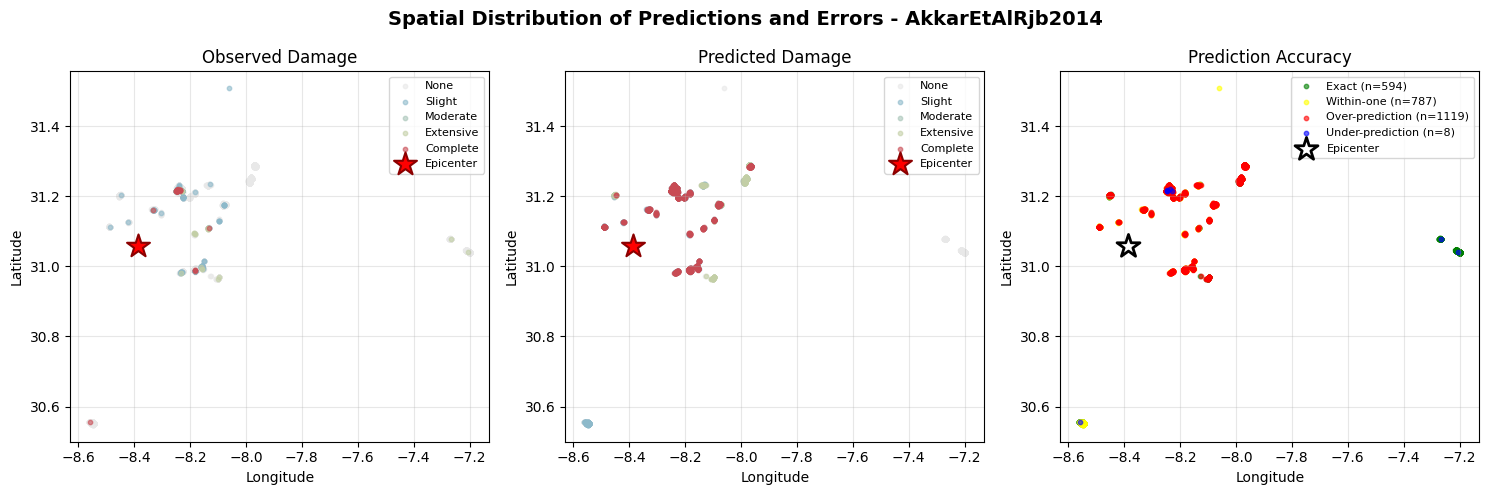


  Spatial error statistics:
    Exact: 594 buildings (23.7%)
    Within-one: 787 buildings (31.4%)
    Over-prediction: 1119 buildings (44.6%)
    Under-prediction: 8 buildings (0.3%)

  Epicenter location: 31.058°N, -8.385°E

ChiouYoungs2014:


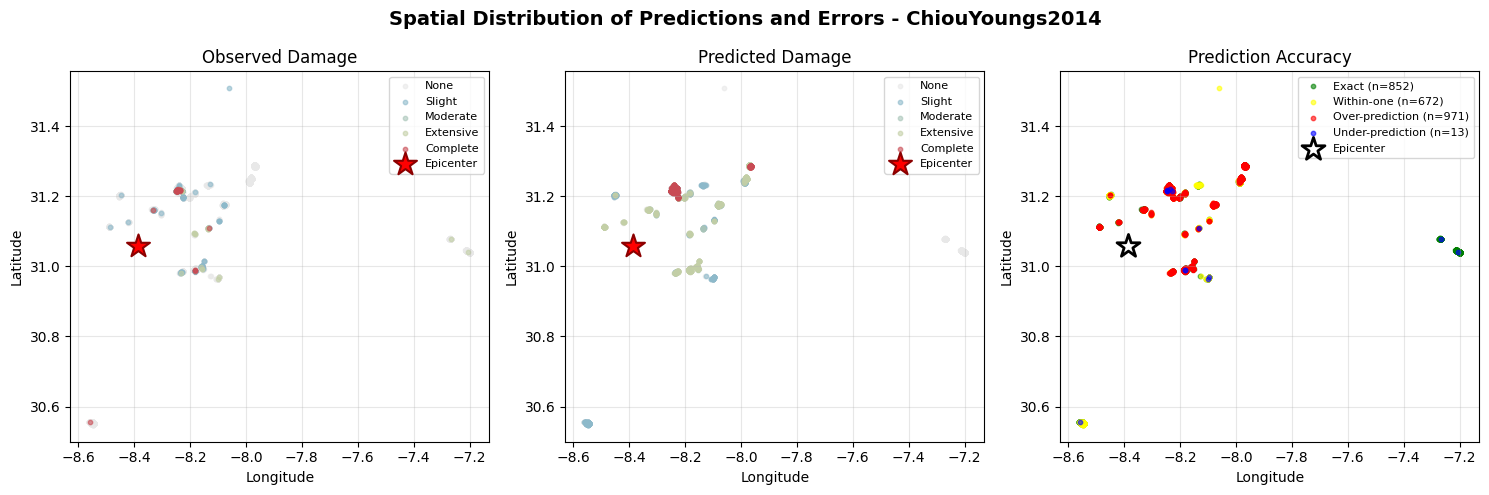


  Spatial error statistics:
    Exact: 852 buildings (34.0%)
    Within-one: 672 buildings (26.8%)
    Over-prediction: 971 buildings (38.7%)
    Under-prediction: 13 buildings (0.5%)

  Epicenter location: 31.058°N, -8.385°E


In [ ]:
print("\n" + "=" * 70)
print("SPATIAL ERROR ANALYSIS")
print("=" * 70)

def create_spatial_error_maps(data):
    """Create maps showing spatial distribution of prediction errors with epicenter."""

    # Epicenter coordinates
    epicenter_lat = 31.058
    epicenter_lon = -8.385

    for gmpe_model, df in data.items():
        print(f"\n{gmpe_model}:")

        # Calculate prediction error metrics and categorize
        ds_to_ordinal = {'None': 0, 'Slight': 1, 'Moderate': 2, 'Extensive': 3, 'Complete': 4}

        df['obs_ord'] = df['observed_ds'].map(ds_to_ordinal)
        df['pred_ord'] = df['most_probable_ds'].map(ds_to_ordinal)
        df['error'] = df['pred_ord'] - df['obs_ord']

        # Categorize predictions
        df['category'] = 'Exact'
        df.loc[df['error'] > 0, 'category'] = 'Over-prediction'
        df.loc[df['error'] < 0, 'category'] = 'Under-prediction'
        df.loc[abs(df['error']) == 1, 'category'] = 'Within-one'
        df.loc[df['error'] == 0, 'category'] = 'Exact'

        # Create spatial visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Map 1: Actual damage
        ax = axes[0]
        for ds, color in zip(['None', 'Slight', 'Moderate', 'Extensive', 'Complete'],
                            ['#E8E8E8', '#8DB9CA', '#A8C4B8', '#C3CFA6', '#C94B54']):
            ds_data = df[df['observed_ds'] == ds]
            if len(ds_data) > 0:
                ax.scatter(ds_data['longitude'], ds_data['latitude'],
                          c=color, s=10, alpha=0.6, label=ds)

        # Add epicenter
        ax.scatter(epicenter_lon, epicenter_lat, marker='*', s=300,
                  color='red', edgecolors='darkred', linewidths=1.5,
                  label='Epicenter', zorder=5)

        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Observed Damage')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)

        # Map 2: Predicted damage
        ax = axes[1]
        for ds, color in zip(['None', 'Slight', 'Moderate', 'Extensive', 'Complete'],
                            ['#E8E8E8', '#8DB9CA', '#A8C4B8', '#C3CFA6', '#C94B54']):
            ds_data = df[df['most_probable_ds'] == ds]
            if len(ds_data) > 0:
                ax.scatter(ds_data['longitude'], ds_data['latitude'],
                          c=color, s=10, alpha=0.6, label=ds)

        # Add epicenter
        ax.scatter(epicenter_lon, epicenter_lat, marker='*', s=300,
                  color='red', edgecolors='darkred', linewidths=1.5,
                  label='Epicenter', zorder=5)

        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Predicted Damage')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)

        # Map 3: Prediction error with categories
        ax = axes[2]

        # Colors for categories (same as uncertainty plots)
        category_colors = {
            'Exact': 'green',
            'Within-one': 'yellow',
            'Over-prediction': 'red',
            'Under-prediction': 'blue'
        }

        # Plot each category
        for category, color in category_colors.items():
            cat_data = df[df['category'] == category]
            if len(cat_data) > 0:
                ax.scatter(cat_data['longitude'], cat_data['latitude'],
                          c=color, s=10, alpha=0.6, label=f'{category} (n={len(cat_data)})')

        # Add epicenter
        ax.scatter(epicenter_lon, epicenter_lat, marker='*', s=300,
                  color='white', edgecolors='black', linewidths=2,
                  label='Epicenter', zorder=5)

        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Prediction Accuracy')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)

        fig.suptitle(f'Spatial Distribution of Predictions and Errors - {gmpe_model}',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Spatial clustering analysis
        print(f"\n  Spatial error statistics:")

        # Calculate statistics by category
        for category in ['Exact', 'Within-one', 'Over-prediction', 'Under-prediction']:
            cat_data = df[df['category'] == category]
            if len(cat_data) > 0:
                print(f"    {category}: {len(cat_data)} buildings ({len(cat_data)/len(df)*100:.1f}%)")

        print(f"\n  Epicenter location: {epicenter_lat}°N, {epicenter_lon}°E")

create_spatial_error_maps(comparison_data)


AkkarEtAlRjb2014:


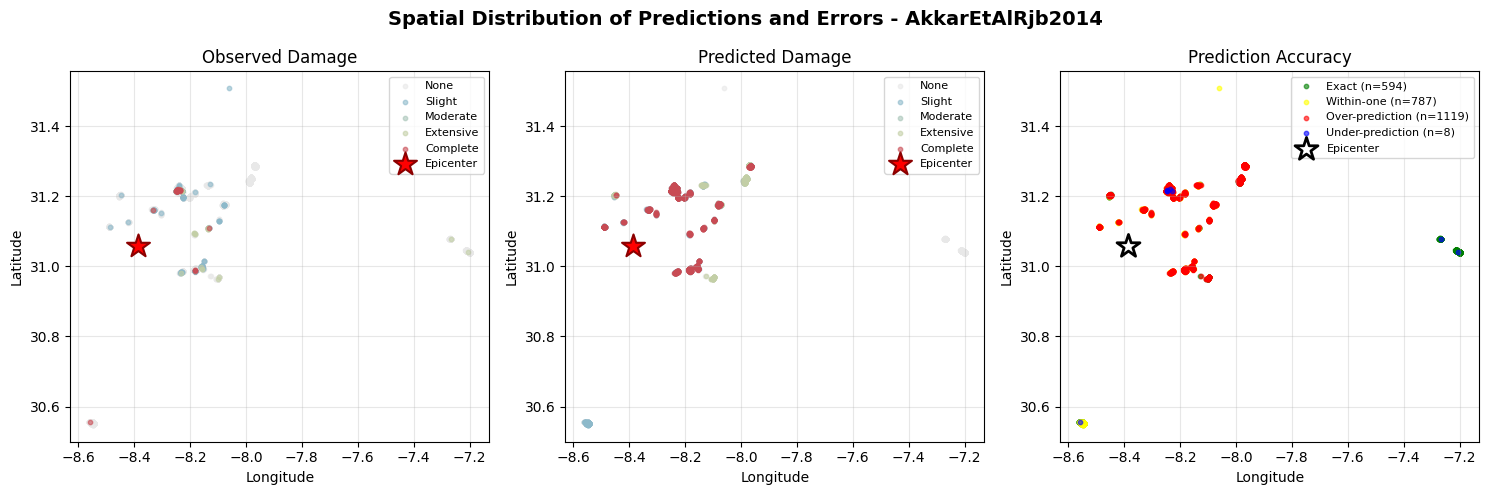


  Spatial error statistics:
    Exact: 594 buildings (23.7%)
    Within-one: 787 buildings (31.4%)
    Over-prediction: 1119 buildings (44.6%)
    Under-prediction: 8 buildings (0.3%)

  Epicenter location: 31.058°N, -8.385°E

ChiouYoungs2014:


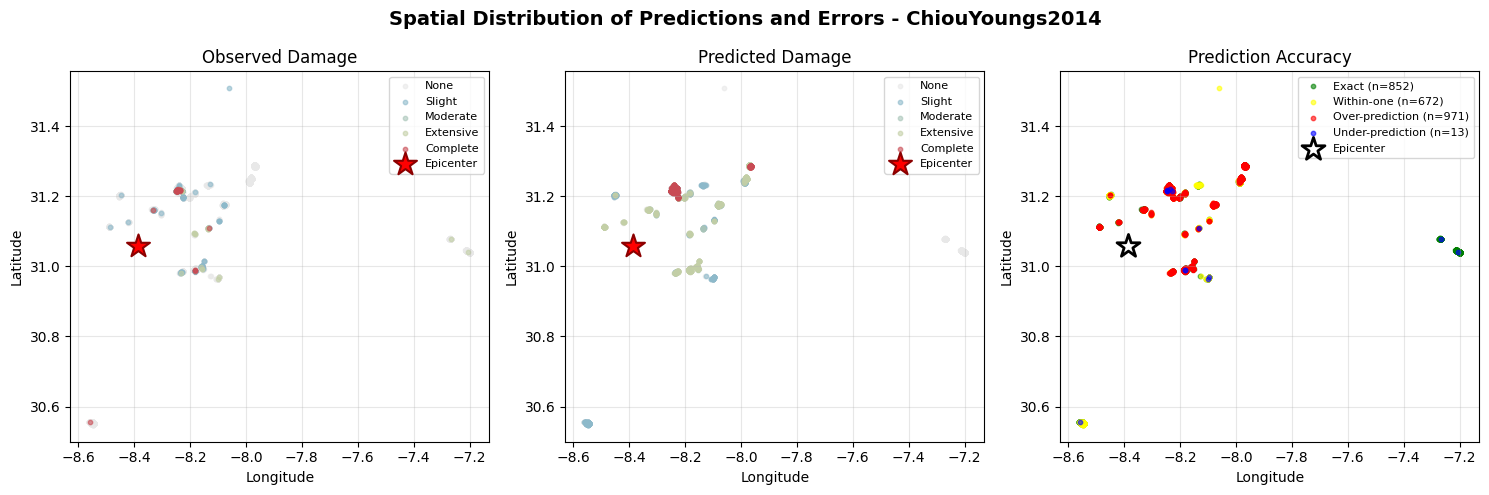


  Spatial error statistics:
    Exact: 852 buildings (34.0%)
    Within-one: 672 buildings (26.8%)
    Over-prediction: 971 buildings (38.7%)
    Under-prediction: 13 buildings (0.5%)

  Epicenter location: 31.058°N, -8.385°E


In [ ]:
def create_spatial_error_maps_surveyed_only(data):
    """Create spatial maps for surveyed buildings only (excluding DG0)."""

    epicenter_lat = 31.058
    epicenter_lon = -8.385

    for gmpe_model, df_full in data.items():
        # Filter to surveyed buildings only
        df = df_full[df_full['observed_ds'] != 'None'].copy()

        print(f"\n{gmpe_model} - Surveyed Buildings Only:")
        print(f"  Mapping {len(df)} surveyed buildings")

        # Calculate prediction error metrics and categorize
        ds_to_ordinal = {'None': 0, 'Slight': 1, 'Moderate': 2, 'Extensive': 3, 'Complete': 4}

        df['obs_ord'] = df['observed_ds'].map(ds_to_ordinal)
        df['pred_ord'] = df['most_probable_ds'].map(ds_to_ordinal)
        df['error'] = df['pred_ord'] - df['obs_ord']

        # Categorize predictions
        df['category'] = 'Exact'
        df.loc[df['error'] > 0, 'category'] = 'Over-prediction'
        df.loc[df['error'] < 0, 'category'] = 'Under-prediction'
        df.loc[abs(df['error']) == 1, 'category'] = 'Within-one'
        df.loc[df['error'] == 0, 'category'] = 'Exact'

        # Create spatial visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Map 1: Actual damage
        ax = axes[0]
        for ds, color in zip(['None', 'Slight', 'Moderate', 'Extensive', 'Complete'],
                            ['#E8E8E8', '#8DB9CA', '#A8C4B8', '#C3CFA6', '#C94B54']):
            ds_data = df[df['observed_ds'] == ds]
            if len(ds_data) > 0:
                ax.scatter(ds_data['longitude'], ds_data['latitude'],
                          c=color, s=10, alpha=0.6, label=ds)

        # Add epicenter
        ax.scatter(epicenter_lon, epicenter_lat, marker='*', s=300,
                  color='red', edgecolors='darkred', linewidths=1.5,
                  label='Epicenter', zorder=5)

        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Observed Damage')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)

        # Map 2: Predicted damage
        ax = axes[1]
        for ds, color in zip(['None', 'Slight', 'Moderate', 'Extensive', 'Complete'],
                            ['#E8E8E8', '#8DB9CA', '#A8C4B8', '#C3CFA6', '#C94B54']):
            ds_data = df[df['most_probable_ds'] == ds]
            if len(ds_data) > 0:
                ax.scatter(ds_data['longitude'], ds_data['latitude'],
                          c=color, s=10, alpha=0.6, label=ds)

        # Add epicenter
        ax.scatter(epicenter_lon, epicenter_lat, marker='*', s=300,
                  color='red', edgecolors='darkred', linewidths=1.5,
                  label='Epicenter', zorder=5)

        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Predicted Damage')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)

        # Map 3: Prediction error with categories
        ax = axes[2]

        # Colors for categories (same as uncertainty plots)
        category_colors = {
            'Exact': 'green',
            'Within-one': 'yellow',
            'Over-prediction': 'red',
            'Under-prediction': 'blue'
        }

        # Plot each category
        for category, color in category_colors.items():
            cat_data = df[df['category'] == category]
            if len(cat_data) > 0:
                ax.scatter(cat_data['longitude'], cat_data['latitude'],
                          c=color, s=10, alpha=0.6, label=f'{category} (n={len(cat_data)})')

        # Add epicenter
        ax.scatter(epicenter_lon, epicenter_lat, marker='*', s=300,
                  color='white', edgecolors='black', linewidths=2,
                  label='Epicenter', zorder=5)

        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Prediction Accuracy')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)

        fig.suptitle(f'Spatial Distribution of Predictions and Errors - {gmpe_model}',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Spatial clustering analysis
        print(f"\n  Spatial error statistics:")

        # Calculate statistics by category
        for category in ['Exact', 'Within-one', 'Over-prediction', 'Under-prediction']:
            cat_data = df[df['category'] == category]
            if len(cat_data) > 0:
                print(f"    {category}: {len(cat_data)} buildings ({len(cat_data)/len(df)*100:.1f}%)")

        print(f"\n  Epicenter location: {epicenter_lat}°N, {epicenter_lon}°E")

create_spatial_error_maps(comparison_data)

# 8. EXPORT MISFIT RESULTS

In [ ]:
print("\n" + "=" * 70)
print("EXPORTING MISFIT ANALYSIS RESULTS")
print("=" * 70)

# Create summary DataFrame
summary_data = []

for gmpe_model, results in misfit_results.items():
    summary_data.append({
        'GMPE_Model': gmpe_model,
        'Metric_Type': 'Overall',
        'Building_Class': 'All',
        'N_Buildings': results['total_buildings'],
        'Normalized_Deviance': results['normalized_deviance'],
        'Weighted_Kappa_p50': results['kappa_p50'],
        'Accuracy': results['accuracy'],
        'Within_One_Accuracy': results['within_one_accuracy'],
        'Over_Prediction_Rate': results['over_prediction_rate'],
        'Under_Prediction_Rate': results['under_prediction_rate']
    })

    # Add class-specific results
    if gmpe_model in class_specific_results:
        for building_class, class_results in class_specific_results[gmpe_model].items():
            summary_data.append({
                'GMPE_Model': gmpe_model,
                'Metric_Type': 'Class-Specific',
                'Building_Class': building_class,
                'N_Buildings': class_results['n_buildings'],
                'Normalized_Deviance': class_results['normalized_deviance'],
                'Weighted_Kappa_p50': class_results['kappa'],
                'Accuracy': class_results['accuracy'],
                'Within_One_Accuracy': class_results['within_one_accuracy'],
                'Over_Prediction_Rate': None,
                'Under_Prediction_Rate': None
            })

summary_df = pd.DataFrame(summary_data)

# Export to CSV
output_filename = f'{OUTPUT_FOLDER}misfit_analysis_results.csv'
summary_df.to_csv(output_filename, index=False)
print(f"✓ Exported misfit analysis results: {output_filename}")

# Display final summary table
print("\n" + "=" * 70)
print("FINAL MISFIT ANALYSIS SUMMARY")
print("=" * 70)

print("\nBest Performing Model (by metric):")
print("-" * 40)

# Find best model for each metric
metrics_to_compare = ['normalized_deviance', 'kappa_p50', 'accuracy', 'within_one_accuracy']
for metric in metrics_to_compare:
    if metric == 'normalized_deviance':  # Lower is better
        best_model = min(misfit_results.keys(),
                        key=lambda x: misfit_results[x][metric])
        best_value = misfit_results[best_model][metric]
        print(f"  Lowest {metric}: {best_model} ({best_value:.4f})")
    else:  # Higher is better
        best_model = max(misfit_results.keys(),
                        key=lambda x: misfit_results[x].get(metric, -999))
        best_value = misfit_results[best_model].get(metric, 0)
        if metric == 'kappa_p50':
            print(f"  Highest weighted kappa: {best_model} ({best_value:.3f})")
        else:
            print(f"  Highest {metric}: {best_model} ({best_value:.1%})")

print("\n" + "=" * 70)
print("SCRIPT 3 COMPLETED SUCCESSFULLY")
print("=" * 70)
print("\nKey Findings:")
print("- Deviance quantifies the likelihood-based misfit")
print("- Weighted kappa accounts for ordinal nature of damage states")
print("- Building class-specific analysis reveals performance variations")
print("- Results exported for further analysis and reporting")

In [ ]:
import pandas as pd

# Load one of the comparison files
df = pd.read_csv('/content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/comparison_ready_AkkarEtAlRjb2014.csv')

print("Data inspection:")
print(f"Total rows: {len(df)}")
print(f"\nFirst 5 rows of damage state columns:")
print(df[['id', 'observed_ds', 'most_probable_ds', 'most_probable_ds_p50']].head())

print(f"\nValue counts for most_probable_ds:")
print(df['most_probable_ds'].value_counts(dropna=False))

print(f"\nNumber of empty/NaN values:")
print(f"most_probable_ds: {df['most_probable_ds'].isna().sum()} NaN, {(df['most_probable_ds'] == '').sum()} empty")
print(f"most_probable_ds_p50: {df['most_probable_ds_p50'].isna().sum()} NaN, {(df['most_probable_ds_p50'] == '').sum()} empty")

print(f"\nExceedance probabilities sample:")
print(df[['id', 'p_exceed_slight', 'p_exceed_moderate', 'p_exceed_extensive', 'p_exceed_complete']].head())

print(f"\nCheck if probabilities are all NaN:")
prob_cols = ['p_exceed_slight', 'p_exceed_moderate', 'p_exceed_extensive', 'p_exceed_complete']
for col in prob_cols:
    print(f"{col}: {df[col].isna().sum()} NaN values")

Data inspection:
Total rows: 2508

First 5 rows of damage state columns:
   id observed_ds most_probable_ds most_probable_ds_p50
0   1      Slight           Slight               Slight
1   7      Slight           Slight               Slight
2  10      Slight           Slight               Slight
3  47    Moderate           Slight               Slight
4  48      Slight           Slight               Slight

Value counts for most_probable_ds:
most_probable_ds
Complete     904
Slight       851
NaN          468
Extensive    270
Moderate      15
Name: count, dtype: int64

Number of empty/NaN values:
most_probable_ds: 468 NaN, 0 empty
most_probable_ds_p50: 468 NaN, 0 empty

Exceedance probabilities sample:
   id  p_exceed_slight  p_exceed_moderate  p_exceed_extensive  \
0   1         0.831261           0.088371            0.046995   
1   7         0.757624           0.051956            0.028855   
2  10         0.841858           0.095870            0.050721   
3  47         0.842714        